<a href="https://colab.research.google.com/github/YonghwanYim/RL-toy-example/blob/main/RL_Toy_Example_36_random_stopping_replace_constant_data3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning + RL
(NASA C-MAPSS dataset)

# Data Handling

Connect with Google Drive

In [560]:
from google.colab import drive
drive.mount('content')

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


Importing libraries

In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Defining features names

In [562]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

Importing train and validation data

* Data Set : FD001
* Train trajectories : 100
* Test trajectories : 100
* Conditions : ONE (Sea Level)
* Fault Modes : ONE (HPC Degradation)

Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. here are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.





**Data Set: FD002**
*   Train trjectories: 260
*   Conditions: SIX
*   Fault Modes: ONE (HPC Degradation)

**Data Set: FD003**
* Train trjectories: 100
* Conditions: ONE (Sea Level)
* Fault Modes: TWO (HPC Degradation, Fan Degradation)

**Data Set: FD004**
* Train trjectories: 249
* Conditions: SIX
* Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [563]:
dftrain = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD003_1_70.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD003_71_100.txt',sep='\s+',header=None,index_col=False,names=col_names)
dffull_data = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD003.txt',sep='\s+',header=None,index_col=False,names=col_names)
# y_valid : A vector of true Remaining Useful Life (RUL) values for the test data.
# y_valid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
# dfvalid.shape

In [564]:
train = dftrain.copy() # Engine 1~70 (dataset 1)
valid = dfvalid.copy() # Engine 71~100 (dataset 1)
full_data = dffull_data.copy() # Engine 1~100 (dataset 1)

Data inspection

In [565]:
train

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0005     0.0004      100.0  518.67   
1                1            2     0.0008    -0.0003      100.0  518.67   
2                1            3    -0.0014    -0.0002      100.0  518.67   
3                1            4    -0.0020     0.0001      100.0  518.67   
4                1            5     0.0016     0.0000      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
17524           70          168    -0.0022    -0.0003      100.0  518.67   
17525           70          169     0.0043    -0.0003      100.0  518.67   
17526           70          170     0.0003     0.0003      100.0  518.67   
17527           70          171    -0.0001    -0.0002      100.0  518.67   
17528           70          172    -0.0008    -0.0003      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      642.36  1583.23  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246   
1      642.50  1584.69  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403   
2      642.18  1582.35  1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901   
3      642.92  1585.61  1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878   
4      641.68  1588.63  1397.65  14.62  ...  522.58  2388.03  8147.80  8.3869   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
17524  643.54  1603.12  1422.68  14.62  ...  520.10  2388.22  8147.01  8.4679   
17525  643.85  1595.64  1430.62  14.62  ...  519.72  2388.19  8144.00  8.5197   
17526  643.47  1604.84  1427.24  14.62  ...  520.31  2388.23  8144.52  8.5237   
17527  643.54  1605.11  1430.07  14.62  ...  520.03  2388.26  8143.76  8.5429   
17528  644.04  1602.65  1431.45  14.62  ...  519.57  2388.24  8146.31  8.5515   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   391  2388  100.0  39.11  23.3537  
1      0.03   392  2388  100.0  38.99  23.4491  
2      0.03   391  2388  100.0  38.85  23.3669  
3      0.03   392  2388  100.0  38.96  23.2951  
4      0.03   392  2388  100.0  39.14  23.4583  
...     ...   ...   ...    ...    ...      ...  
17524  0.03   396  2388  100.0  38.69  23.0561  
17525  0.03   397  2388  100.0  38.51  23.0839  
17526  0.03   396  2388  100.0  38.41  23.0512  
17527  0.03   396  2388  100.0  38.37  23.0493  
17528  0.03   396  2388  100.0  38.39  23.0936  

[17529 rows x 26 columns]

In [566]:
valid

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0              71            1    -0.0003     0.0001      100.0  518.67   
1              71            2    -0.0038    -0.0002      100.0  518.67   
2              71            3    -0.0027    -0.0003      100.0  518.67   
3              71            4     0.0029    -0.0003      100.0  518.67   
4              71            5    -0.0007     0.0002      100.0  518.67   
...           ...          ...        ...        ...        ...     ...   
7186          100          148    -0.0016    -0.0003      100.0  518.67   
7187          100          149     0.0034    -0.0003      100.0  518.67   
7188          100          150    -0.0016     0.0004      100.0  518.67   
7189          100          151    -0.0023     0.0004      100.0  518.67   
7190          100          152     0.0000     0.0003      100.0  518.67   

         s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0     642.08  1581.48  1400.26  14.62  ...  517.77  2387.76  8120.80  8.4192   
1     641.52  1581.05  1394.00  14.62  ...  518.98  2387.84  8130.14  8.4414   
2     641.70  1575.72  1390.85  14.62  ...  520.35  2387.95  8132.44  8.3852   
3     642.02  1574.43  1396.86  14.62  ...  518.76  2387.56  8120.28  8.4243   
4     642.30  1580.29  1395.08  14.62  ...  519.53  2387.43  8122.43  8.4014   
...      ...      ...      ...    ...  ...     ...      ...      ...     ...   
7186  643.78  1596.01  1424.11  14.62  ...  519.66  2388.30  8138.08  8.5036   
7187  643.29  1596.38  1429.14  14.62  ...  519.91  2388.28  8144.36  8.5174   
7188  643.84  1604.53  1431.41  14.62  ...  519.44  2388.24  8135.95  8.5223   
7189  643.94  1597.56  1426.57  14.62  ...  520.01  2388.26  8141.24  8.5148   
7190  643.64  1599.04  1436.06  14.62  ...  519.48  2388.24  8136.98  8.5150   

      s_16  s_17  s_18   s_19   s_20     s_21  
0     0.03   390  2388  100.0  38.87  23.2429  
1     0.03   389  2388  100.0  38.88  23.2883  
2     0.03   392  2388  100.0  38.83  23.3616  
3     0.03   391  2388  100.0  39.01  23.2899  
4     0.03   392  2388  100.0  38.85  23.3676  
...    ...   ...   ...    ...    ...      ...  
7186  0.03   394  2388  100.0  38.44  22.9631  
7187  0.03   395  2388  100.0  38.50  22.9746  
7188  0.03   396  2388  100.0  38.39  23.0682  
7189  0.03   395  2388  100.0  38.31  23.0753  
7190  0.03   396  2388  100.0  38.56  23.0847  

[7191 rows x 26 columns]

In [567]:
full_data

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0005     0.0004      100.0  518.67   
1                1            2     0.0008    -0.0003      100.0  518.67   
2                1            3    -0.0014    -0.0002      100.0  518.67   
3                1            4    -0.0020     0.0001      100.0  518.67   
4                1            5     0.0016     0.0000      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
24715          100          148    -0.0016    -0.0003      100.0  518.67   
24716          100          149     0.0034    -0.0003      100.0  518.67   
24717          100          150    -0.0016     0.0004      100.0  518.67   
24718          100          151    -0.0023     0.0004      100.0  518.67   
24719          100          152     0.0000     0.0003      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      642.36  1583.23  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246   
1      642.50  1584.69  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403   
2      642.18  1582.35  1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901   
3      642.92  1585.61  1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878   
4      641.68  1588.63  1397.65  14.62  ...  522.58  2388.03  8147.80  8.3869   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
24715  643.78  1596.01  1424.11  14.62  ...  519.66  2388.30  8138.08  8.5036   
24716  643.29  1596.38  1429.14  14.62  ...  519.91  2388.28  8144.36  8.5174   
24717  643.84  1604.53  1431.41  14.62  ...  519.44  2388.24  8135.95  8.5223   
24718  643.94  1597.56  1426.57  14.62  ...  520.01  2388.26  8141.24  8.5148   
24719  643.64  1599.04  1436.06  14.62  ...  519.48  2388.24  8136.98  8.5150   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   391  2388  100.0  39.11  23.3537  
1      0.03   392  2388  100.0  38.99  23.4491  
2      0.03   391  2388  100.0  38.85  23.3669  
3      0.03   392  2388  100.0  38.96  23.2951  
4      0.03   392  2388  100.0  39.14  23.4583  
...     ...   ...   ...    ...    ...      ...  
24715  0.03   394  2388  100.0  38.44  22.9631  
24716  0.03   395  2388  100.0  38.50  22.9746  
24717  0.03   396  2388  100.0  38.39  23.0682  
24718  0.03   395  2388  100.0  38.31  23.0753  
24719  0.03   396  2388  100.0  38.56  23.0847  

[24720 rows x 26 columns]

In [568]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (17529, 26)
Shape of the validation dataset :  (7191, 26)
Percentage of the validation dataset :  0.2908980582524272


Add RUL column to the data

RUL corresponds to the remaining time cycles for each unit before it falls.

In [569]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [570]:
train = add_RUL_column(train)
valid = add_RUL_column(valid)
full_data = add_RUL_column(full_data)

In [571]:
train[['unit_number','RUL']] # Jet Engine 1~70 (total : 70)

unit_number  RUL
0                1  258
1                1  257
2                1  256
3                1  255
4                1  254
...            ...  ...
17524           70    4
17525           70    3
17526           70    2
17527           70    1
17528           70    0

[17529 rows x 2 columns]

In [572]:
valid[['unit_number','RUL']] # Jet Engine 71~100 (total : 30)

unit_number  RUL
0              71  408
1              71  407
2              71  406
3              71  405
4              71  404
...           ...  ...
7186          100    4
7187          100    3
7188          100    2
7189          100    1
7190          100    0

[7191 rows x 2 columns]

In [573]:
full_data[['unit_number', 'RUL']]

unit_number  RUL
0                1  258
1                1  257
2                1  256
3                1  255
4                1  254
...            ...  ...
24715          100    4
24716          100    3
24717          100    2
24718          100    1
24719          100    0

[24720 rows x 2 columns]

In [574]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

Plotting the evolution of features (sensors) along with the evolution with RUL

In [575]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
      #plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())
       if (i % 5 == 0):   #For a better visualisation, we plot the sensors signals of 10 units only (data : FD001)
           plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero  # xlim() : range of x-axis
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

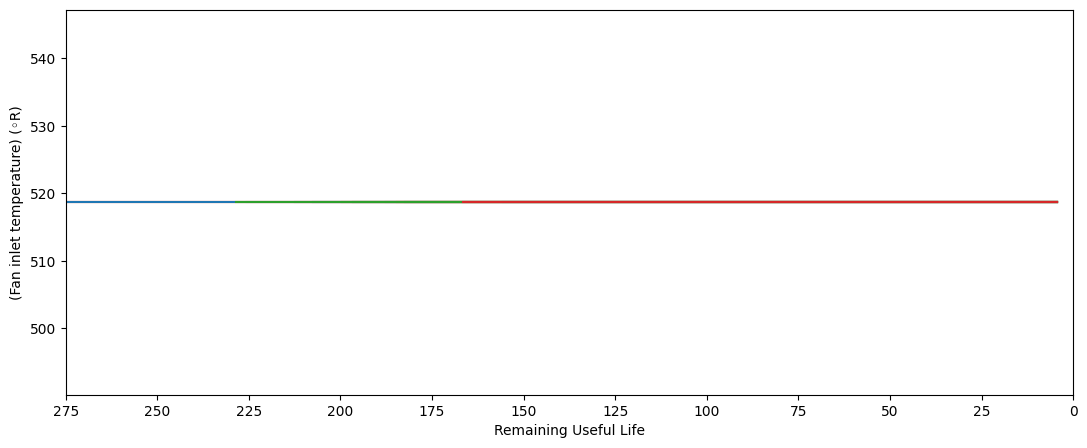

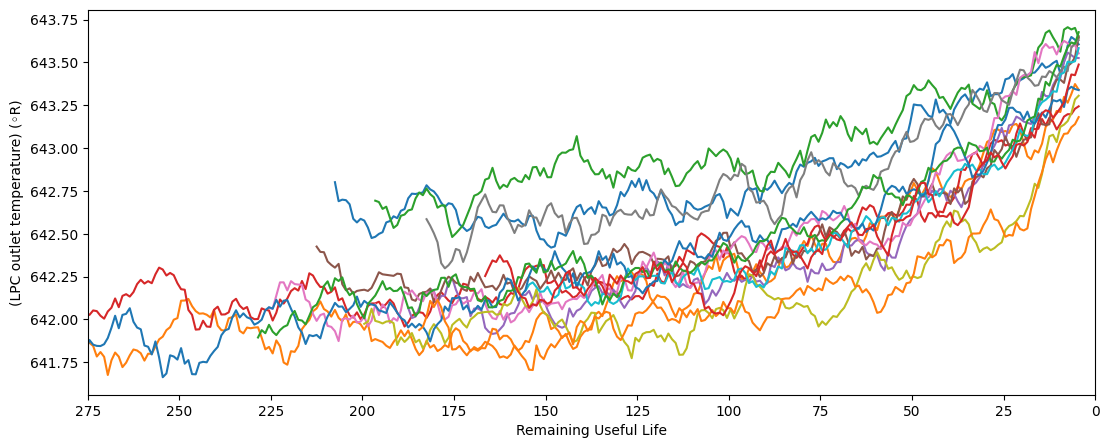

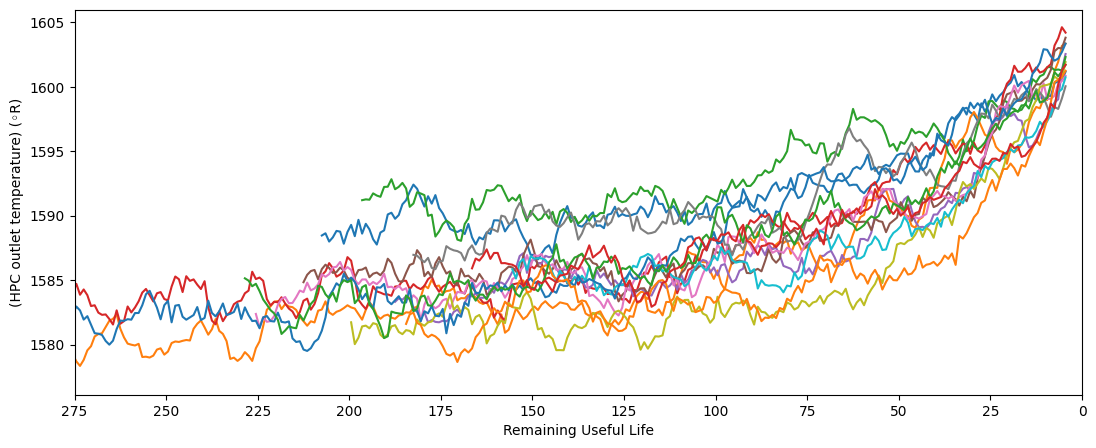

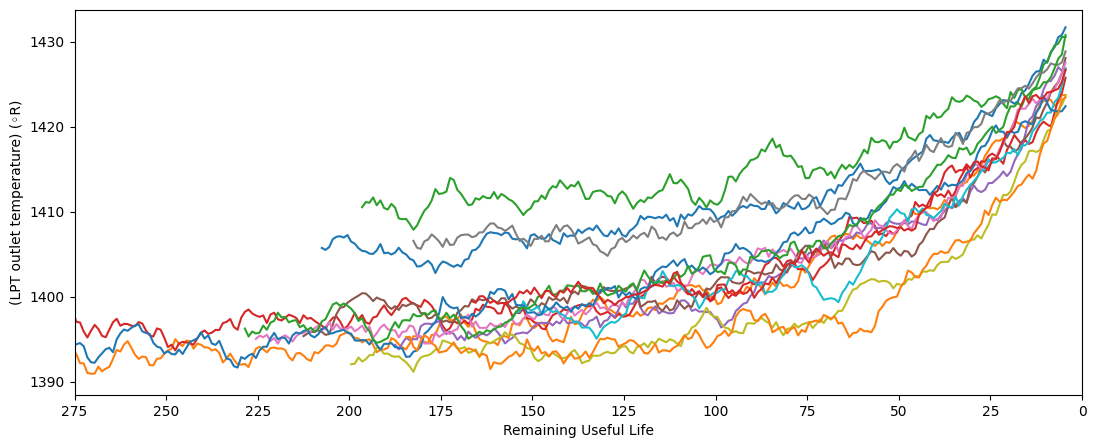

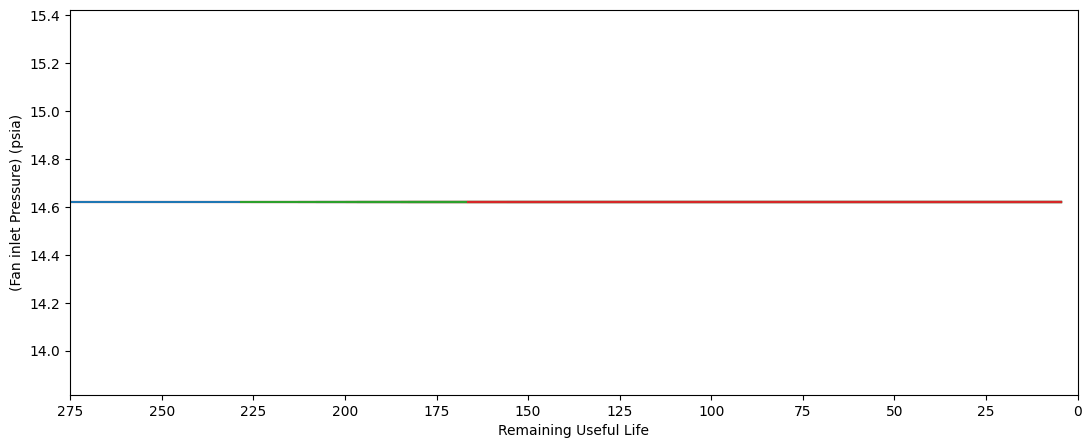

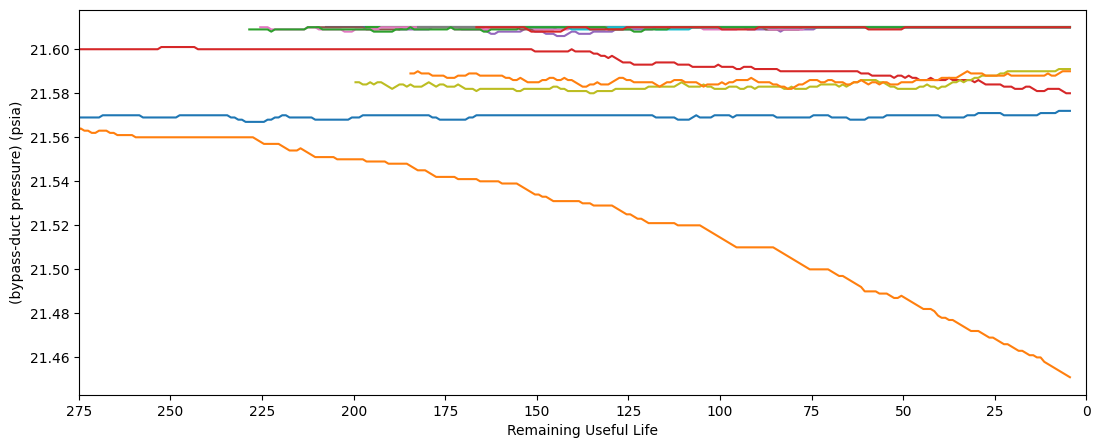

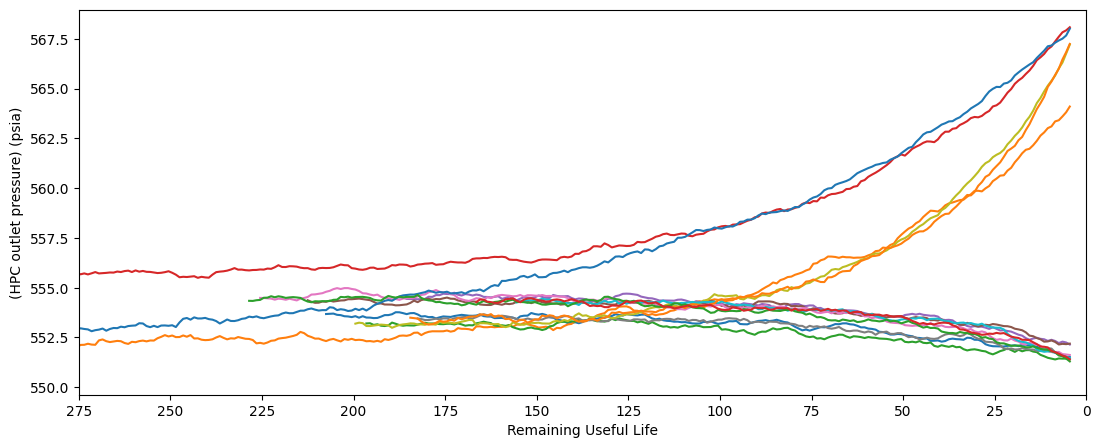

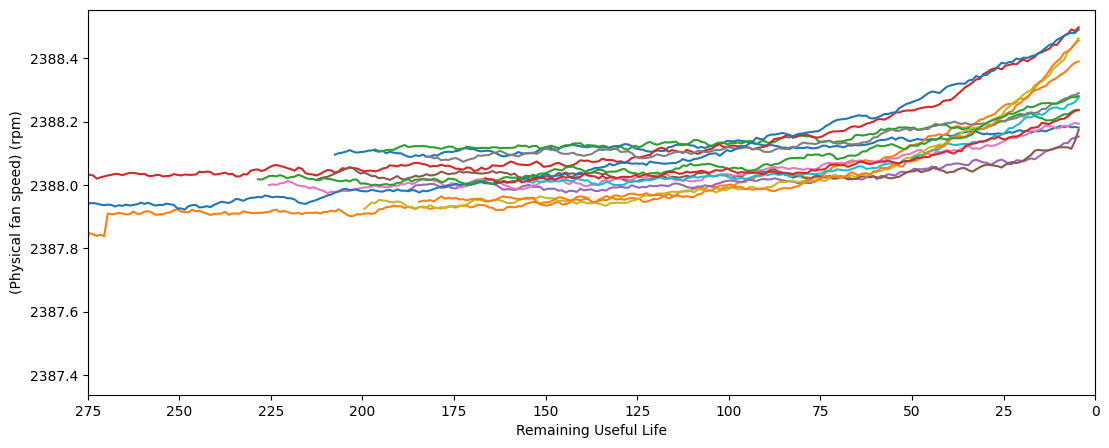

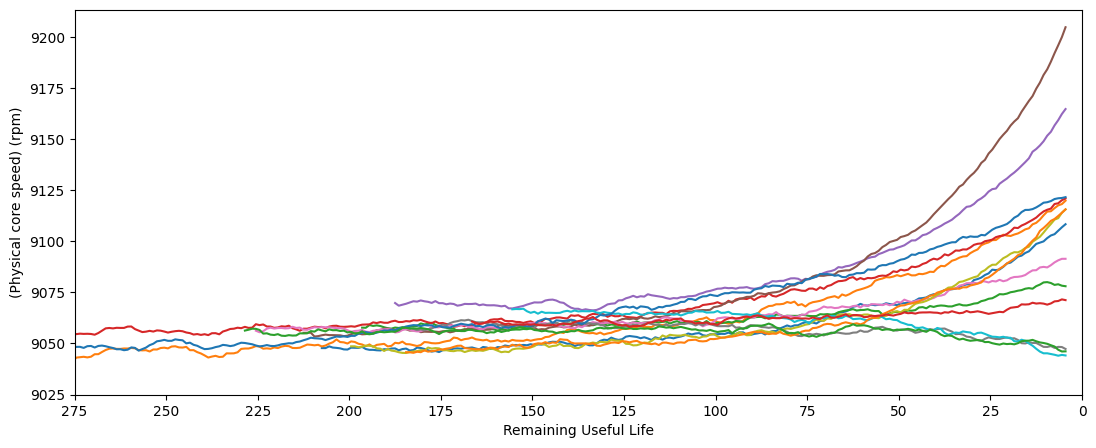

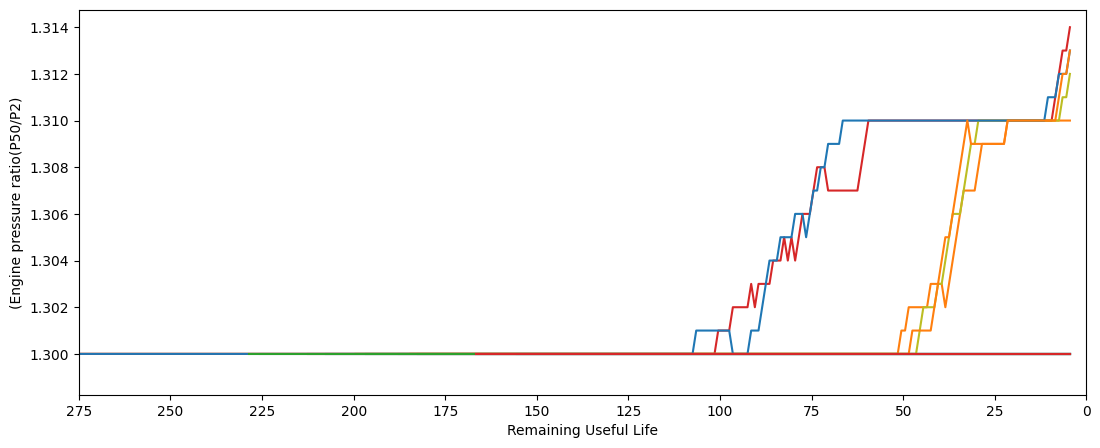

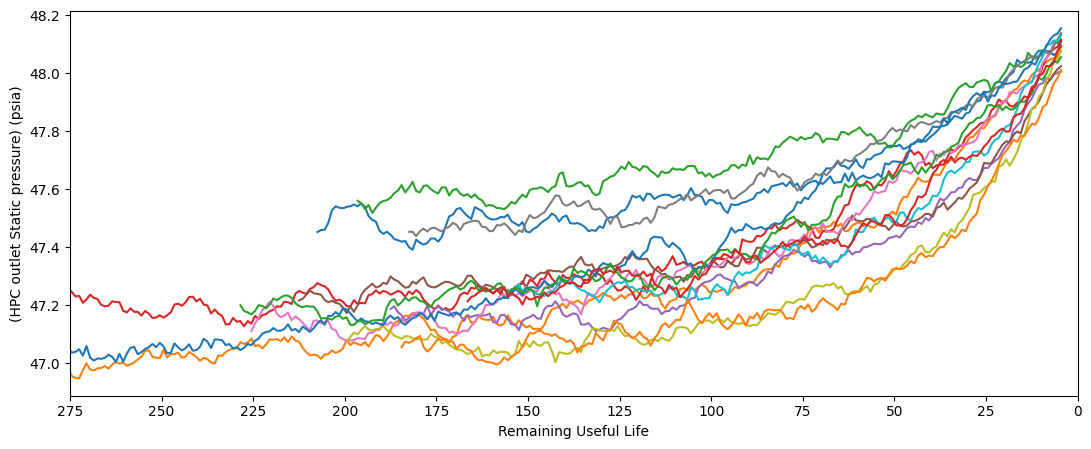

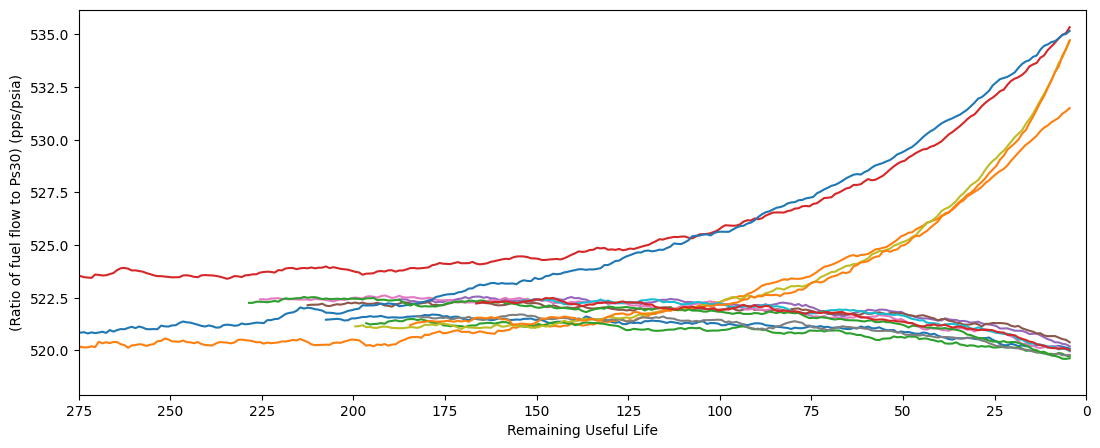

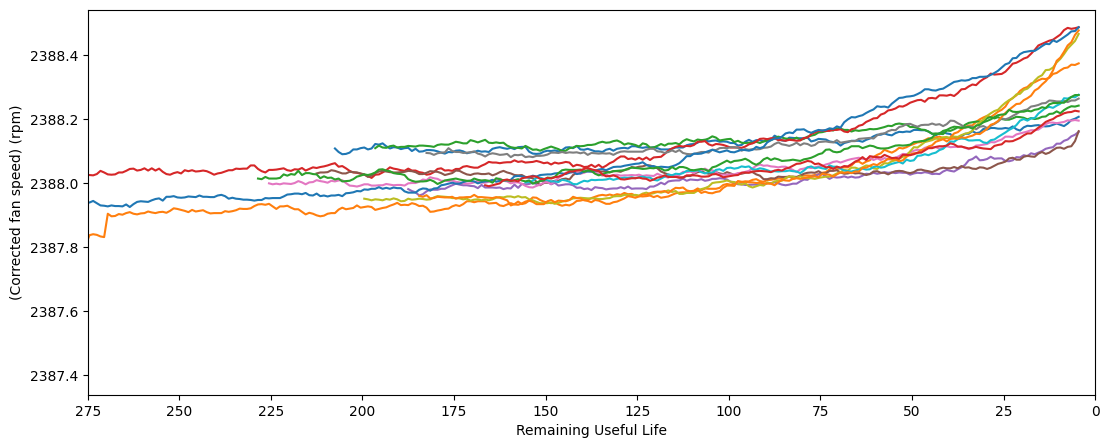

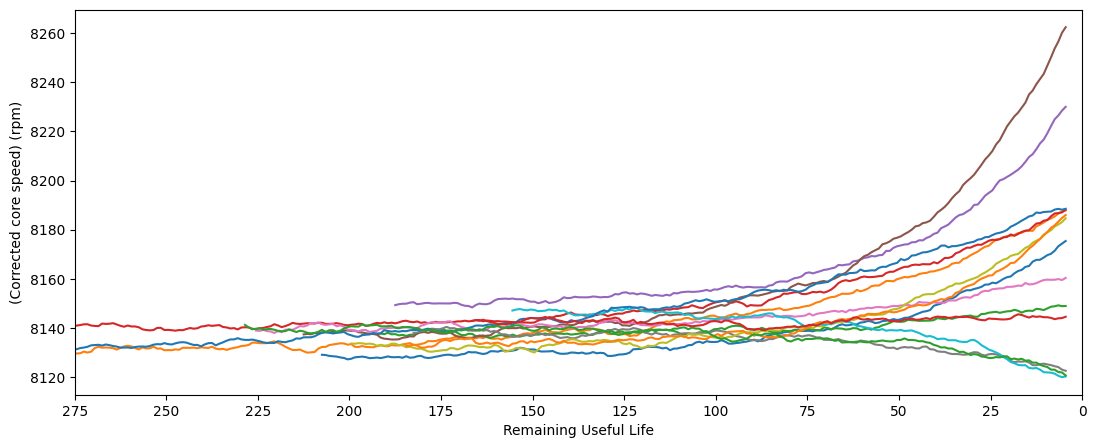

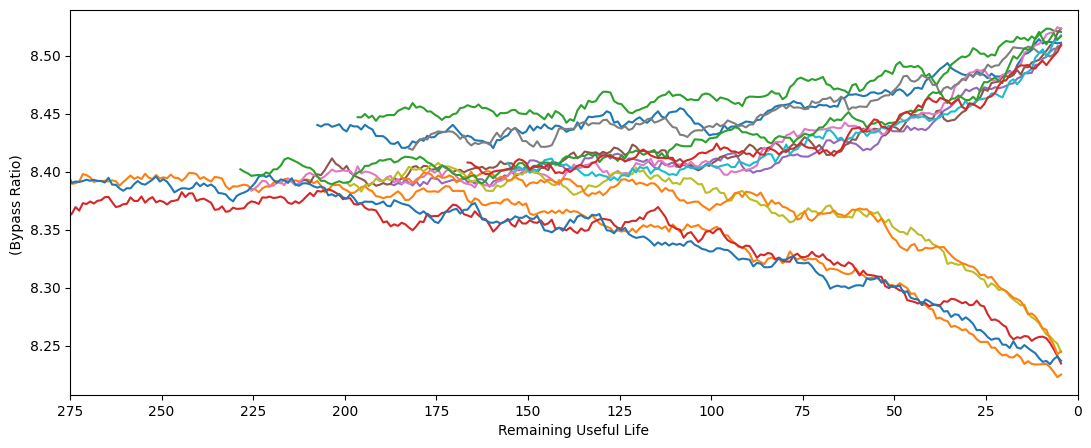

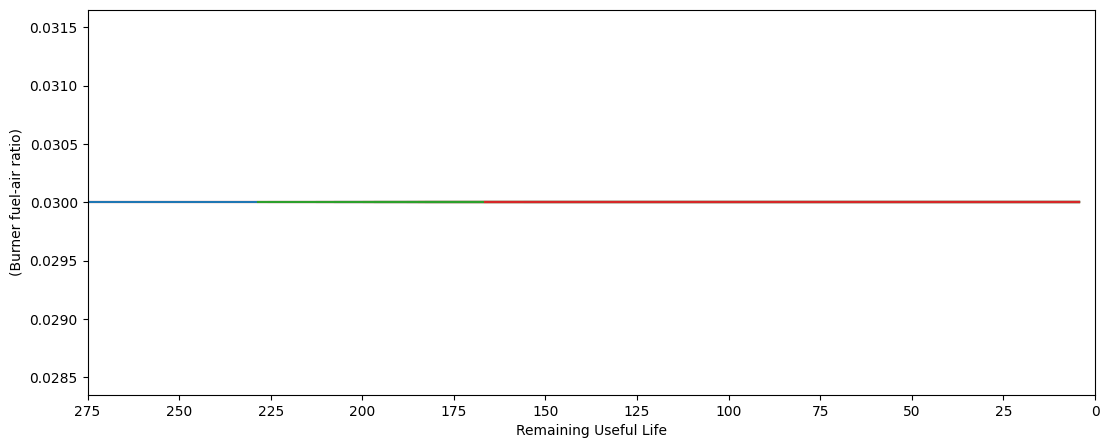

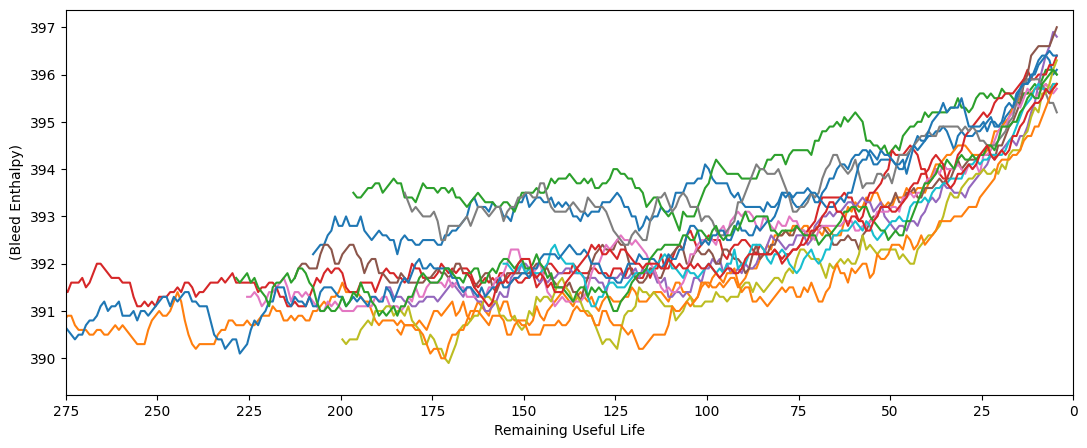

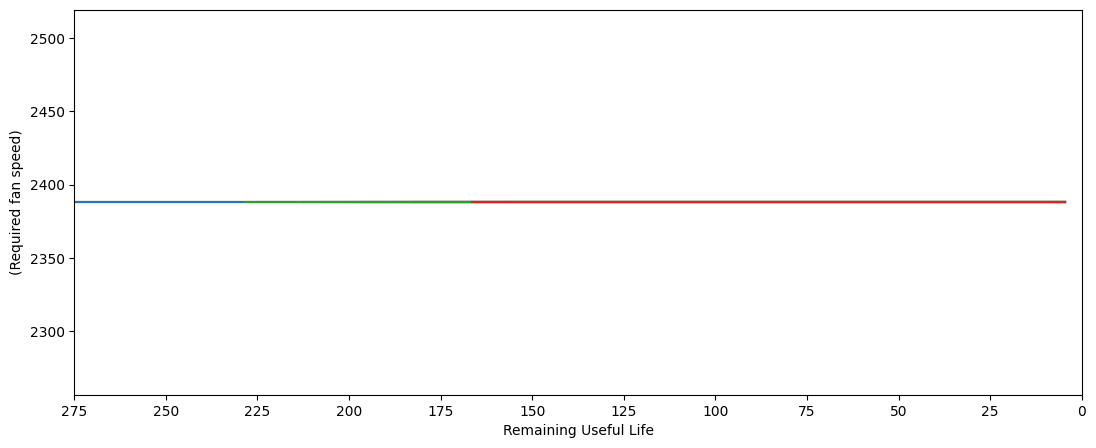

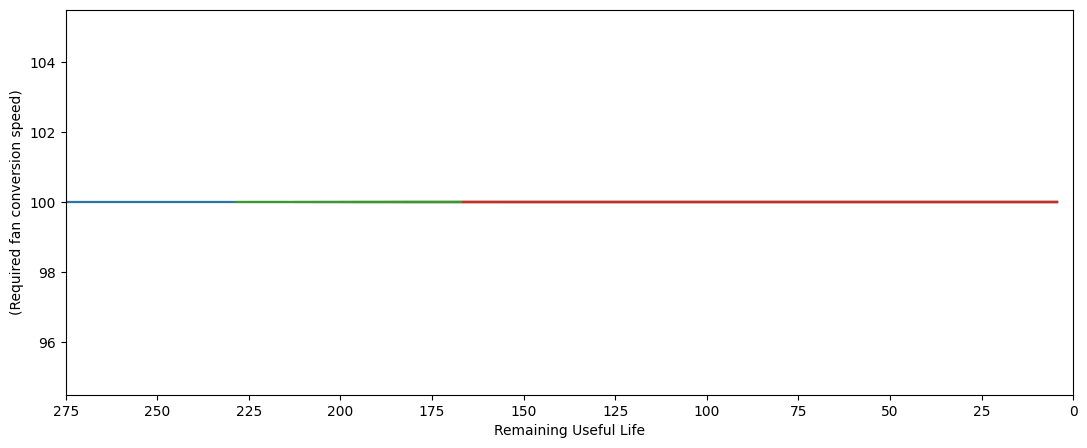

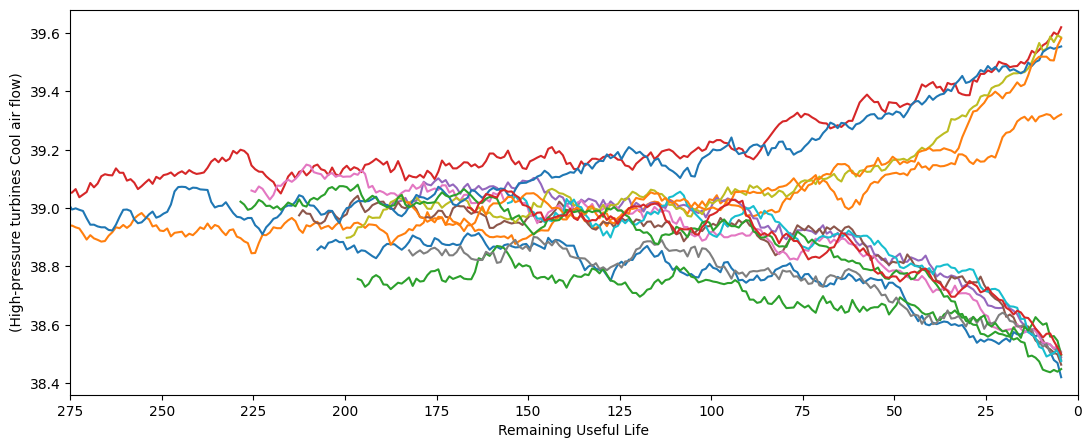

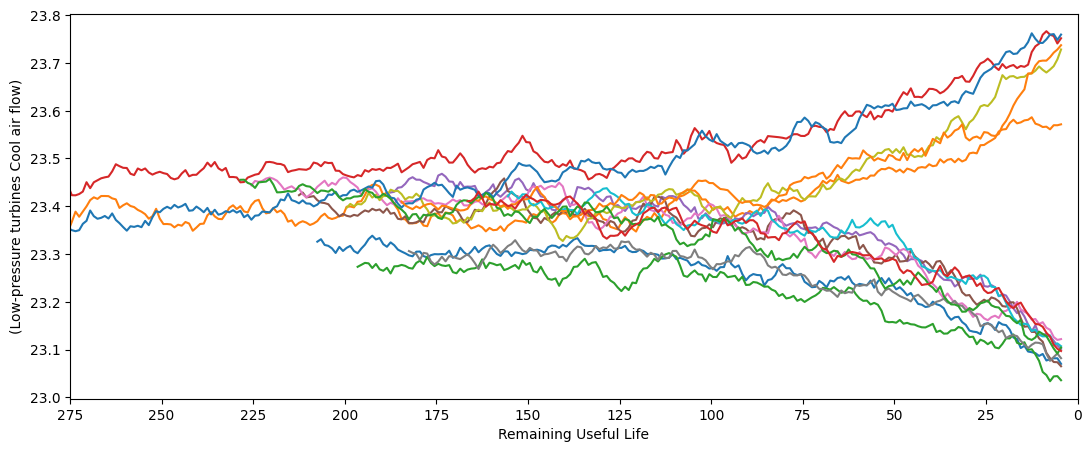

In [576]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

In [577]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   17529.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2   17529.0   642.456737  5.277827e-01   640.8400   642.0700   642.4000   
s_3   17529.0  1588.052022  6.865455e+00  1564.3000  1583.2000  1587.4700   
s_4   17529.0  1404.441645  9.931666e+00  1377.0600  1396.9800  1402.8600   
s_5   17529.0    14.620000  3.552815e-15    14.6200    14.6200    14.6200   
s_6   17529.0    21.596744  1.884430e-02    21.4500    21.5800    21.6100   
s_7   17529.0   554.952255  3.348767e+00   549.6100   553.0400   553.9400   
s_8   17529.0  2388.067975  1.579436e-01  2386.9000  2388.0000  2388.0700   
s_9   17529.0  9063.767836  2.057996e+01  9021.9300  9051.1500  9059.3500   
s_10  17529.0     1.301115  3.348194e-03     1.2900     1.3000     1.3000   
s_11  17529.0    47.413785  3.027559e-01    46.6900    47.1900    47.3600   
s_12  17529.0   522.868619  3.169536e+00   517.7800   521.1000   521.8900   
s_13  17529.0  2388.068168  1.576391e-01  2386.9300  2388.0000  2388.0700   
s_14  17529.0  8143.900390  1.704635e+01  8102.9200  8133.8400  8140.5300   
s_15  17529.0     8.399658  5.949510e-02     8.1563     8.3664     8.4020   
s_16  17529.0     0.030000  1.387818e-17     0.0300     0.0300     0.0300   
s_17  17529.0   392.553654  1.776825e+00   388.0000   391.0000   392.0000   
s_18  17529.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  17529.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  17529.0    38.975697  2.467082e-01    38.1700    38.8200    38.9700   
s_21  17529.0    23.385844  1.474839e-01    22.8995    23.2907    23.3835   
RUL   17529.0   139.180501  9.965508e+01     0.0000    62.0000   125.0000   

            75%        max  
s_1    518.6700   518.6700  
s_2    642.7900   645.1100  
s_3   1592.4500  1615.3900  
s_4   1410.7500  1441.1600  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    555.6600   570.4900  
s_8   2388.1400  2388.6000  
s_9   9069.5100  9234.3500  
s_10     1.3000     1.3200  
s_11    47.6100    48.4400  
s_12   523.4800   537.4000  
s_13  2388.1400  2388.6100  
s_14  8148.7800  8290.5500  
s_15     8.4390     8.5705  
s_16     0.0300     0.0300  
s_17   394.0000   399.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    39.1300    39.8400  
s_21    23.4737    23.9505  
RUL    190.0000   524.0000

MinMax scaler function : Transform features by scaling each feature to a given range.

This estimater scales and translates each feature individually such that it is in the given range on the training set

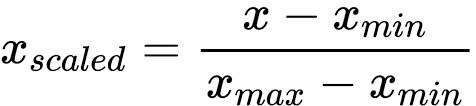

Dropping unnecessary features (labels and settings)

Scaling the data (Min-Max scaler)

In [578]:
def min_max_scaling(column):
    min_value = column.min()
    max_value = column.max()
    scaled_column = (column - min_value) / (max_value - min_value)

    # NaN 값을 0으로 바꿔줌
    scaled_column = scaled_column.fillna(0)

    return scaled_column

In [579]:
columns_to_scale = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
train[columns_to_scale] = train[columns_to_scale].apply(min_max_scaling, axis=0)
valid[columns_to_scale] = valid[columns_to_scale].apply(min_max_scaling, axis=0)
full_data[columns_to_scale] = full_data[columns_to_scale].apply(min_max_scaling, axis=0)

Test code

In [580]:
print(train)
print(valid)
print(full_data)

       unit_number  time_cycles  setting_1  setting_2  setting_3  s_1  \
0                1            1    -0.0005     0.0004      100.0  0.0   
1                1            2     0.0008    -0.0003      100.0  0.0   
2                1            3    -0.0014    -0.0002      100.0  0.0   
3                1            4    -0.0020     0.0001      100.0  0.0   
4                1            5     0.0016     0.0000      100.0  0.0   
...            ...          ...        ...        ...        ...  ...   
17524           70          168    -0.0022    -0.0003      100.0  0.0   
17525           70          169     0.0043    -0.0003      100.0  0.0   
17526           70          170     0.0003     0.0003      100.0  0.0   
17527           70          171    -0.0001    -0.0002      100.0  0.0   
17528           70          172    -0.0008    -0.0003      100.0  0.0   

            s_2       s_3       s_4  s_5  ...      s_13      s_14      s_15  \
0      0.355972  0.370523  0.308580  0.0  ..

# Model Implementation

**Linear regression**

# **Loss function Tuning**

**1. Original MSE**

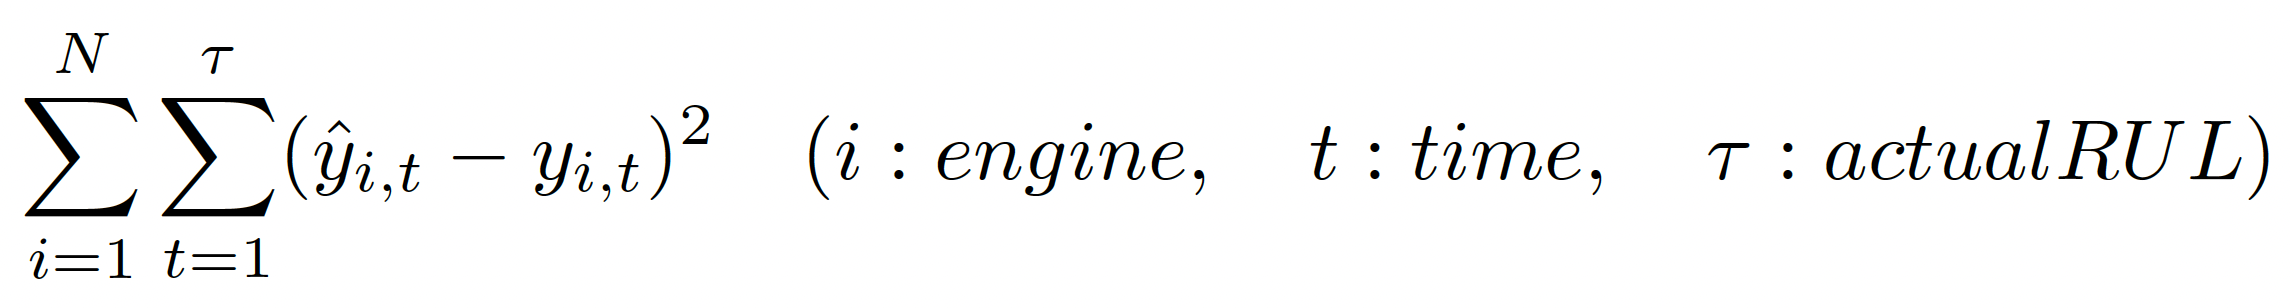

In [581]:
"""
# 1. Original Linear Regression (모든 데이터 사용)
lr1 = LinearRegression()

lr1.fit(X_train_1_s, y_train_clip) #Fitting

y_lr_train_1 = lr1.predict(X_train_1_s) #Prediction on train data

y_lr_valid_1 = lr1.predict(X_valid_1_s) #Prediction on validation data

y_lr_full_1 = lr1.predict(X_full_1_s) #Prediction on full data

print(lr1.coef_)
"""

'\n# 1. Original Linear Regression (모든 데이터 사용)\nlr1 = LinearRegression()\n\nlr1.fit(X_train_1_s, y_train_clip) #Fitting\n\ny_lr_train_1 = lr1.predict(X_train_1_s) #Prediction on train data\n\ny_lr_valid_1 = lr1.predict(X_valid_1_s) #Prediction on validation data\n\ny_lr_full_1 = lr1.predict(X_full_1_s) #Prediction on full data\n\nprint(lr1.coef_)\n'

**2. Crucial moments Loss function**

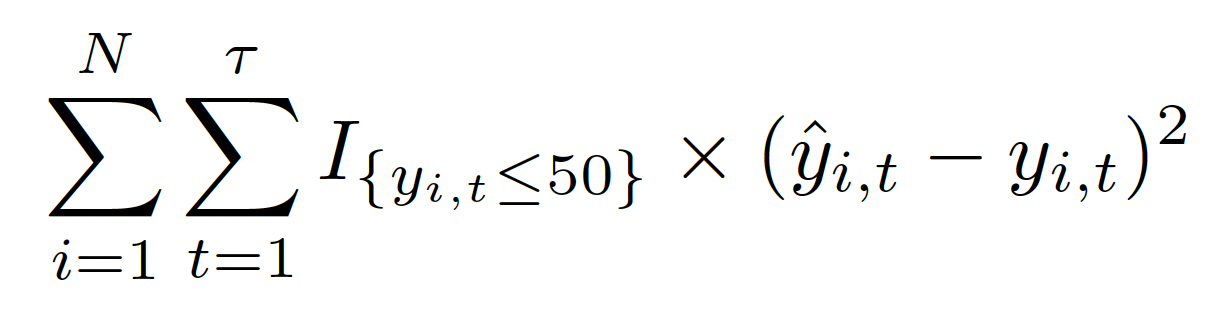

In [582]:
"""
# 2. Crucial moments loss function - Linear Regression

# Filter and save only data that is less than 50.
filtered_data = X_train_1_s[y_train_clip <= 50]
filtered_labels = y_train_clip[y_train_clip <= 50]

lr2 = LinearRegression()

lr2.fit(filtered_data, filtered_labels) #Fitting

y_lr_train_2 = lr2.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_2, label='train')

y_lr_valid_2 = lr2.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_2, label='valid')

y_lr_full_2 = lr2.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_2, label='full data')

print(lr2.coef_)
"""

"\n# 2. Crucial moments loss function - Linear Regression\n\n# Filter and save only data that is less than 50.\nfiltered_data = X_train_1_s[y_train_clip <= 50]\nfiltered_labels = y_train_clip[y_train_clip <= 50]\n\nlr2 = LinearRegression()\n\nlr2.fit(filtered_data, filtered_labels) #Fitting\n\ny_lr_train_2 = lr2.predict(X_train_1_s) #Prediction on train data\nevaluate(y_train_clip, y_lr_train_2, label='train')\n\ny_lr_valid_2 = lr2.predict(X_valid_1_s) #Prediction on validation data\nevaluate(y_valid, y_lr_valid_2, label='valid')\n\ny_lr_full_2 = lr2.predict(X_full_1_s) #Prediction on full data\nevaluate(y_full, y_lr_full_2, label='full data')\n\nprint(lr2.coef_)\n"

**3. TD Style Loss function (ridge regression)**

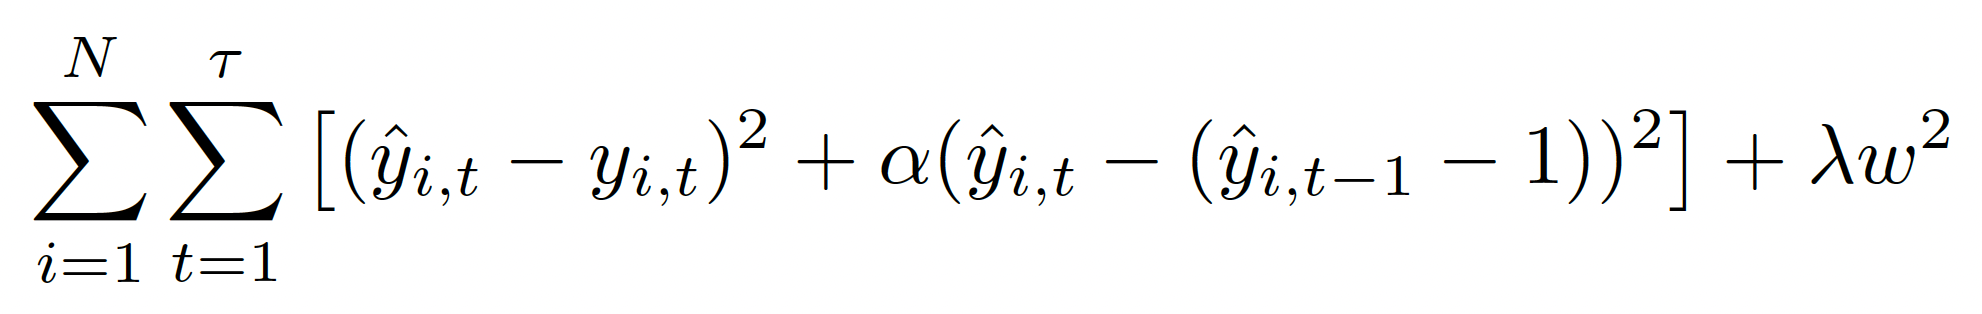

In [583]:
"""
# Multi var linear regression

class Linear_Regression_TD() :
  def __init__( self, alpha=0, lambda_ridge=0 ) :
    self.alpha = alpha
    self.lambda_ridge = lambda_ridge  # Ridge regression

  def fit(self, X, Y, alpha, lambd) :
    self.l, self.p = X.shape
    self.alpha = alpha
    self.lambda_ridge = lambd
    # weight initializer
    self.p = (self.p + 1)         # add constant term.

    self.add_X = np.ones(self.l)
    self.X = np.c_[self.add_X, X]

    self.array_Y = np.array(Y[0:].to_numpy())
    self.array_Y.reshape( self.l, 1 )
    self.Y = self.array_Y
    self.W = np.zeros( self.p ) # W : 0 (b is included)

    self.identity = np.identity( n = self.p ) # Ridge regression
    self.lambda_identity = self.lambda_ridge * self.identity   # lambda * I

    # 각각의 행렬 연산
    X_T_X = (self.X.T) @ (self.X)          # X^(T)X
    X_diff_T_X_diff_sum = np.zeros( [self.p, self.p] )

    for i in range(1, self.l):
      X_diff_T_X_diff = (( self.X[i, :] - self.X[i - 1, :] ).reshape(self.p, 1)) @ (( self.X[i, :] - self.X[i - 1, :] ).reshape(1, self.p))
      X_diff_T_X_diff_sum += X_diff_T_X_diff


    X_T_Y = (self.X.T) @ (self.Y)
    X_T_Y = X_T_Y.reshape( self.p, 1 )
    X_diff_T_sum = np.zeros( [self.p, 1] )

    for i in range(1, self.l):
      X_diff_T = (( self.X[i, :] - self.X[i - 1, :] ).reshape( self.p, 1 ))
      X_diff_T_sum += X_diff_T

    self.W = np.linalg.inv(X_T_X + (self.alpha * X_diff_T_X_diff_sum) + self.lambda_identity) @ (X_T_Y - self.alpha * X_diff_T_sum)

    print(self.W)
    print(self.W.shape)

# X를 입력 받으면 첫 열에 1의 값을 갖는 열을 추가해서 계산해야함. (입력으로 들어오는 X는 (n, 21)이니 (n, 22)로 바꿔줘야 함)
  def predict( self, X) :
    l_X, p_X = X.shape
    p_X = p_X + 1
    add_col = np.ones(l_X)

    X = np.c_[add_col, X]

    return X.dot( self.W )
"""

'\n# Multi var linear regression\n\nclass Linear_Regression_TD() :\n  def __init__( self, alpha=0, lambda_ridge=0 ) :\n    self.alpha = alpha\n    self.lambda_ridge = lambda_ridge  # Ridge regression\n\n  def fit(self, X, Y, alpha, lambd) :\n    self.l, self.p = X.shape\n    self.alpha = alpha\n    self.lambda_ridge = lambd\n    # weight initializer\n    self.p = (self.p + 1)         # add constant term.\n\n    self.add_X = np.ones(self.l)\n    self.X = np.c_[self.add_X, X]\n\n    self.array_Y = np.array(Y[0:].to_numpy())\n    self.array_Y.reshape( self.l, 1 )\n    self.Y = self.array_Y\n    self.W = np.zeros( self.p ) # W : 0 (b is included)\n\n    self.identity = np.identity( n = self.p ) # Ridge regression\n    self.lambda_identity = self.lambda_ridge * self.identity   # lambda * I\n\n    # 각각의 행렬 연산\n    X_T_X = (self.X.T) @ (self.X)          # X^(T)X\n    X_diff_T_X_diff_sum = np.zeros( [self.p, self.p] )\n\n    for i in range(1, self.l):\n      X_diff_T_X_diff = (( self.X[i, :] -

In [584]:
"""
lr3 = Linear_Regression_TD()

# fit(X, Y, alpha, lambda)        # lambda = 10
lr3.fit(X_train_1_s, y_train_clip, 0.5, 10) #Fitting

y_lr_train_3 = lr3.predict(X_train_1_s) #Prediction on train data

y_lr_valid_3 = lr3.predict(X_valid_1_s) #Prediction on validation data

y_lr_full_3 = lr3.predict(X_full_1_s) #Prediction on full data
"""

'\nlr3 = Linear_Regression_TD()\n\n# fit(X, Y, alpha, lambda)        # lambda = 10\nlr3.fit(X_train_1_s, y_train_clip, 0.5, 10) #Fitting\n\ny_lr_train_3 = lr3.predict(X_train_1_s) #Prediction on train data\n\ny_lr_valid_3 = lr3.predict(X_valid_1_s) #Prediction on validation data\n\ny_lr_full_3 = lr3.predict(X_full_1_s) #Prediction on full data\n'

**4. TD Style Loss function + Crucial moments (ridge regression)**

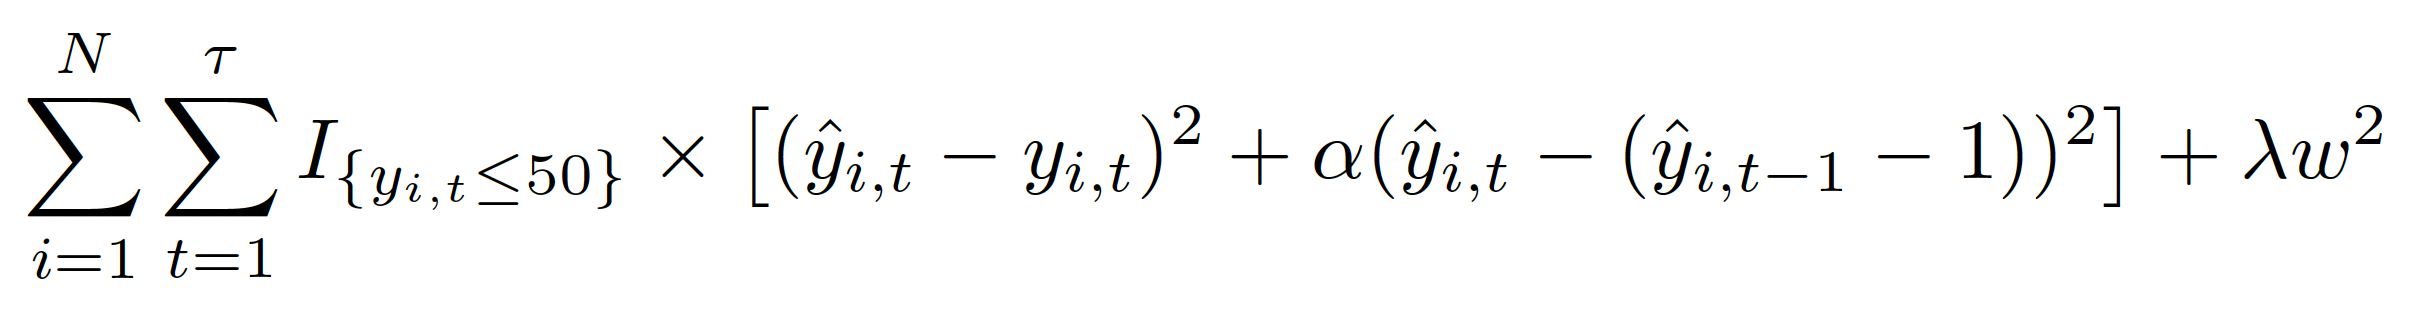

In [585]:
"""
filtered_data_2 = X_train_1_s[y_train_clip <= 50]
filtered_labels_2 = y_train_clip[y_train_clip <= 50]

lr4 = Linear_Regression_TD()

# fit(X, Y, alpha, lambda)        # lambda = 10
lr4.fit(filtered_data_2, filtered_labels_2, 0.5, 10) #Fitting

y_lr_train_4 = lr4.predict(X_train_1_s)
evaluate(y_train_clip, y_lr_train_4, label='train')

y_lr_valid_4 = lr4.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_4, label='valid')

y_lr_full_4 = lr4.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_4, label='full data')
"""

"\nfiltered_data_2 = X_train_1_s[y_train_clip <= 50]\nfiltered_labels_2 = y_train_clip[y_train_clip <= 50]\n\nlr4 = Linear_Regression_TD()\n\n# fit(X, Y, alpha, lambda)        # lambda = 10\nlr4.fit(filtered_data_2, filtered_labels_2, 0.5, 10) #Fitting\n\ny_lr_train_4 = lr4.predict(X_train_1_s)\nevaluate(y_train_clip, y_lr_train_4, label='train')\n\ny_lr_valid_4 = lr4.predict(X_valid_1_s) #Prediction on validation data\nevaluate(y_valid, y_lr_valid_4, label='valid')\n\ny_lr_full_4 = lr4.predict(X_full_1_s) #Prediction on full data\nevaluate(y_full, y_lr_full_4, label='full data')\n"

# What is the best policy parameter?


**Experiment 1 - Gaussian Smoothing**

(Dataset 1, Loss function 1, Theta = 0)

In [586]:
"""
# Importing the library for using the 'deepcopy' method.
import copy

# Through the 'deepcopy' method, I assigned different addresses to lr1 and lr5, making them independent objects.
lr5 = copy.deepcopy(lr1)   # loss function 1의 w,b를 lr5에 저장 (가장 안좋은 parameter를 보고 학습 과정을 지켜보기 위함)
threshold_theta = 0       # initial theta = 10

# Hyper Parameter
GS_lr = 0.0001                  # learning rate
sd = 0.01                      # standard deviation
num_of_epsilon = 7              # for expectation -> mean(epsilon 1, epsilon 2, ... , epsilon n)

# 패널티 텀에 의한 영향을 잠시 제거 (값을 낮춰서)
coef_of_MSE_w = 0.00001         # penalty term of MSE(W)
coef_of_MSE_b = 0.000001         # penalty term of MSE(b)
coef_of_MSE_theta = 0.000001      # penalty term of MSE(theta)


# save initial parameter (for calculate MSE)
initial_parameter = copy.deepcopy(lr5)
initial_theta = threshold_theta

# print
print(lr5.coef_)          # coef_ : w (21-dim)
print(lr5.intercept_)     # intercept_ : b (1-dim)
print(threshold_theta)
"""

"\n# Importing the library for using the 'deepcopy' method.\nimport copy\n\n# Through the 'deepcopy' method, I assigned different addresses to lr1 and lr5, making them independent objects.\nlr5 = copy.deepcopy(lr1)   # loss function 1의 w,b를 lr5에 저장 (가장 안좋은 parameter를 보고 학습 과정을 지켜보기 위함)\nthreshold_theta = 0       # initial theta = 10\n\n# Hyper Parameter\nGS_lr = 0.0001                  # learning rate\nsd = 0.01                      # standard deviation\nnum_of_epsilon = 7              # for expectation -> mean(epsilon 1, epsilon 2, ... , epsilon n)\n\n# 패널티 텀에 의한 영향을 잠시 제거 (값을 낮춰서)\ncoef_of_MSE_w = 0.00001         # penalty term of MSE(W)\ncoef_of_MSE_b = 0.000001         # penalty term of MSE(b)\ncoef_of_MSE_theta = 0.000001      # penalty term of MSE(theta)\n\n\n# save initial parameter (for calculate MSE)\ninitial_parameter = copy.deepcopy(lr5)\ninitial_theta = threshold_theta\n\n# print\nprint(lr5.coef_)          # coef_ : w (21-dim)\nprint(lr5.intercept_)     # intercept_ : b (1-

Scalar 값을 입력으로 받는 MSE 함수 정의

In [587]:
"""
def mean_squared_error_scalar(y_true, y_pred):
    mse = (y_true - y_pred) ** 2
    return mse
"""

'\ndef mean_squared_error_scalar(y_true, y_pred):\n    mse = (y_true - y_pred) ** 2\n    return mse\n'

In [588]:
# test code
"""
print(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))
print(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))
print(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))

print( GS_lr * ( ( gradient_w / (sd ** 2))))
print( GS_lr * ( ( gradient_b / (sd ** 2))))
print( GS_lr * ( ( gradient_theta / (sd ** 2))))
"""

'\nprint(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))\nprint(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))\nprint(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))\n\nprint( GS_lr * ( ( gradient_w / (sd ** 2))))\nprint( GS_lr * ( ( gradient_b / (sd ** 2))))\nprint( GS_lr * ( ( gradient_theta / (sd ** 2))))\n'

In [589]:
"""
## 'Epsilon 여러개 뽑는 version' + 'penalty term'으로 convergence 안정화 ##

# Initialize the DataFrame to store results
simul_result_df = pd.DataFrame(columns=['W', 'b', 'Theta', 'Average usage time', 'Average cost', 'Number of failure'])

# Define the number of iterations (n)
n = 6000  # Change this to the desired number of iterations

for i in range(n):
    # Epsilon ~ N(0,0.1)
    epsilon_w = np.mean([np.random.normal(0, sd, 21) for _ in range(num_of_epsilon)], axis=0)
    epsilon_b = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])
    epsilon_theta = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])

    lr5.coef_ += epsilon_w
    lr5.intercept_ += epsilon_b
    threshold_theta += epsilon_theta

    y_full_prediction = lr5.predict(X_full_1_s)

    # Merge dataframe (label + data)
    y_full_prediction_df = pd.DataFrame(y_full_prediction, columns=['predicted RUL'])
    merged_full_prediction_df = pd.concat([X_full_index_names, y_full_prediction_df, y_full], axis=1)

    cumulative_operation_time = 0
    total_cost = 0
    average_cost = 0

    by_threshold_full_prediction_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])
    grouped = merged_full_prediction_df.groupby('unit_number')

    for unit, group in grouped:
        operation_time = None
        max_RUL = group['RUL'].max()

        for index, row in group.iterrows():
            if row['predicted RUL'] <= threshold_theta:
                operation_time = row['time_cycles']
                cumulative_operation_time += operation_time
                total_cost += REPLACE_COST
                break

        if pd.isna(operation_time):
            cumulative_operation_time += max_RUL
            total_cost += FAILURE_COST

        average_cost = (total_cost / cumulative_operation_time)
        by_threshold_full_prediction_df = by_threshold_full_prediction_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                                                  'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                                                  'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

    simul_average_usage_time = by_threshold_full_prediction_df['Cumulative Operation Time'].iloc[-1] / (len(by_threshold_full_prediction_df.index) + 1)
    simul_average_cost_by_threshold = by_threshold_full_prediction_df['Average Cost'].iloc[-1]
    simul_nan_count = by_threshold_full_prediction_df.loc[:, 'actual operation time'].isna().sum()

    # 앞에서 넣은 epsilon을 다시 제거하고, 원래의 parameter로 되돌림.
    lr5.coef_ -= epsilon_w
    lr5.intercept_ -= epsilon_b
    threshold_theta -= epsilon_theta

    # Expectation 내의 gradient 부분만 계산
    gradient_w = simul_average_cost_by_threshold * epsilon_w          # "f(w+eps, b+eps, theta+eps) * [ epsilon vector ]"에서 w 부분
    gradient_b = simul_average_cost_by_threshold * epsilon_b          # b 부분
    gradient_theta = simul_average_cost_by_threshold * epsilon_theta  # theta 부분


    # test code
    #print(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))
    #print(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))
    #print(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))

    #print( GS_lr * ( ( gradient_w / (sd ** 2))))
    #print( GS_lr * ( ( gradient_b / (sd ** 2))))
    #print( GS_lr * ( ( gradient_theta / (sd ** 2))))


    # [W,b,theta] update  # 여기에 MSE penalty를 넣어줘야 함.
    lr5.coef_ -= ( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) )
    lr5.intercept_ -= ( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) )
    threshold_theta -= ( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) )

    # Append the results to the DataFrame
    simul_result_df = simul_result_df.append({'Iteration' : i + 1, 'W': lr5.coef_.tolist(), 'b': lr5.intercept_.item(), 'Theta': threshold_theta.item(),
                                              'Average usage time': simul_average_usage_time, 'Average cost': simul_average_cost_by_threshold,
                                              'Number of failure': simul_nan_count}, ignore_index=True)

    print("Iteration : ", i + 1, "Average usage time : ", "{:.3f}".format(simul_average_usage_time),
          ", Average cost : ", "{:.3f}".format(simul_average_cost_by_threshold), ", Number of failures : ", simul_nan_count )
"""

'\n## \'Epsilon 여러개 뽑는 version\' + \'penalty term\'으로 convergence 안정화 ##\n\n# Initialize the DataFrame to store results\nsimul_result_df = pd.DataFrame(columns=[\'W\', \'b\', \'Theta\', \'Average usage time\', \'Average cost\', \'Number of failure\'])\n\n# Define the number of iterations (n)\nn = 6000  # Change this to the desired number of iterations\n\nfor i in range(n):\n    # Epsilon ~ N(0,0.1)\n    epsilon_w = np.mean([np.random.normal(0, sd, 21) for _ in range(num_of_epsilon)], axis=0)\n    epsilon_b = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])\n    epsilon_theta = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])\n\n    lr5.coef_ += epsilon_w\n    lr5.intercept_ += epsilon_b\n    threshold_theta += epsilon_theta\n\n    y_full_prediction = lr5.predict(X_full_1_s)\n\n    # Merge dataframe (label + data)\n    y_full_prediction_df = pd.DataFrame(y_full_prediction, columns=[\'predicted RUL\'])\n    merged_full_prediction_df = pd.concat([X_

In [590]:
"""
# Print or use the simul_result_df as needed
print(simul_result_df)
"""

'\n# Print or use the simul_result_df as needed\nprint(simul_result_df)\n'

In [591]:
"""
# Find optimal parameter
optimal_average_cost_row = simul_result_df.iloc[simul_result_df['Average cost'].idxmin()]
print(optimal_average_cost_row)
"""

"\n# Find optimal parameter\noptimal_average_cost_row = simul_result_df.iloc[simul_result_df['Average cost'].idxmin()]\nprint(optimal_average_cost_row)\n"

In [592]:
#optimal_average_cost_row['W']

In [593]:
#optimal_average_cost_row = simul_result_df.iloc[0]
#optimal_average_cost_row['W']

**Loss Plot**

In [594]:
"""
plt.figure(figsize=(10, 6))

# 'Iteration'을 x축으로, 'Average cost'을 y축으로 하는 그래프 그리기
plt.plot(simul_result_df['Iteration'], simul_result_df['Average cost'],
         marker='o', color='b', alpha=0.5)

# 그래프에 레이블 추가
plt.xlabel('Iteration')
plt.ylabel('Average cost')
plt.title('Results')

#plt.ylim(4.95, 10)
#plt.xlim(0, 1500)

# 그래프 표시
#plt.grid(True)  # 그리드 추가
plt.show()
"""

"\nplt.figure(figsize=(10, 6))\n\n# 'Iteration'을 x축으로, 'Average cost'을 y축으로 하는 그래프 그리기\nplt.plot(simul_result_df['Iteration'], simul_result_df['Average cost'],\n         marker='o', color='b', alpha=0.5)\n\n# 그래프에 레이블 추가\nplt.xlabel('Iteration')\nplt.ylabel('Average cost')\nplt.title('Results')\n\n#plt.ylim(4.95, 10)\n#plt.xlim(0, 1500)\n\n# 그래프 표시\n#plt.grid(True)  # 그리드 추가\nplt.show()\n"

**Plot에 optimal point 찍어보기**

"Optimal parameter로 성능 재현"

In [595]:
"""
#optimal_parameter = simul_result_df.iloc[213]    # optimal row
optimal_parameter = optimal_average_cost_row  # optimal row
optimal_w = np.array(optimal_parameter['W'])     # optimal paramter에서 W 추출
optimal_b = optimal_parameter['b']     # optimal paramter에서 b 추출
optimal_theta = optimal_parameter['Theta'] # optimal paramter에서 Theta

lr5.coef_ = optimal_w
lr5.intercept_ = optimal_b
threshold_theta = optimal_theta

y_optimal_prediction = lr5.predict(X_full_1_s)

 # Merge dataframe (label + data)
y_optimal_prediction_df = pd.DataFrame(y_optimal_prediction, columns=['predicted RUL'])
merged_optimal_prediction_df = pd.concat([X_full_index_names, y_optimal_prediction_df, y_full], axis=1)

cumulative_operation_time = 0
total_cost = 0
average_cost = 0


by_threshold_optimal_prediction_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])
grouped = merged_optimal_prediction_df.groupby('unit_number')

for unit, group in grouped:
    operation_time = None
    max_RUL = group['RUL'].max()

    for index, row in group.iterrows():
        if row['predicted RUL'] <= threshold_theta:
            operation_time = row['time_cycles']
            cumulative_operation_time += operation_time
            total_cost += REPLACE_COST
            break

    if pd.isna(operation_time):
        cumulative_operation_time += max_RUL
        total_cost += FAILURE_COST

    average_cost = (total_cost / cumulative_operation_time)
    by_threshold_optimal_prediction_df = by_threshold_optimal_prediction_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                                              'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                                              'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

optimal_average_usage_time = by_threshold_optimal_prediction_df['Cumulative Operation Time'].iloc[-1] / (len(by_threshold_optimal_prediction_df.index) + 1)
optimal_average_cost_by_threshold = by_threshold_optimal_prediction_df['Average Cost'].iloc[-1]
optimal_number_of_failure = by_threshold_optimal_prediction_df.loc[:, 'actual operation time'].isna().sum()


print("Optimal : ", "Average usage time : ", "{:.3f}".format(optimal_average_usage_time),
      ", Average cost : ", "{:.3f}".format(optimal_average_cost_by_threshold), ", Number of failures : ", optimal_number_of_failure )
"""

'\n#optimal_parameter = simul_result_df.iloc[213]    # optimal row\noptimal_parameter = optimal_average_cost_row  # optimal row\noptimal_w = np.array(optimal_parameter[\'W\'])     # optimal paramter에서 W 추출\noptimal_b = optimal_parameter[\'b\']     # optimal paramter에서 b 추출\noptimal_theta = optimal_parameter[\'Theta\'] # optimal paramter에서 Theta\n\nlr5.coef_ = optimal_w\nlr5.intercept_ = optimal_b\nthreshold_theta = optimal_theta\n\ny_optimal_prediction = lr5.predict(X_full_1_s)\n\n # Merge dataframe (label + data)\ny_optimal_prediction_df = pd.DataFrame(y_optimal_prediction, columns=[\'predicted RUL\'])\nmerged_optimal_prediction_df = pd.concat([X_full_index_names, y_optimal_prediction_df, y_full], axis=1)\n\ncumulative_operation_time = 0\ntotal_cost = 0\naverage_cost = 0\n\n\nby_threshold_optimal_prediction_df = pd.DataFrame(columns=[\'unit_number\', \'actual operation time\', \'actual RUL\', \'Cumulative Operation Time\', \'Total Cost\'])\ngrouped = merged_optimal_prediction_df.group

In [596]:
"""
# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'], '+-',
        label=f'Loss function {i + 1}',
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim(191,203) ### for dataset1
#ax.set_ylim(172,205) ### for dataset2
#ax.set_ylim(226,240) ### for dataset3
#ax.set_ylim(190,237) ### for dataset4
ax.set_xlim(-0.5,15)

# Set aspect ratio to make the plot square
#ax.set_aspect('equal')


###########################################################################################

optimal_x = optimal_number_of_failure
optimal_y = optimal_average_usage_time

# Plot a point using the extracted values
ax.plot(
    optimal_x,
    optimal_y,
    'ro',  # 'ro'는 빨간색 원형 점.
    label='Optimal Point'
)
###########################################################################################

# Show the plot
plt.tight_layout()
plt.show()
"""

"\n# Create a list of colors for each dataframe\ncolors = ['blue', 'green', 'red', 'yellow']\n\nfig, ax = plt.subplots(figsize=(6, 6))\n\n# Loop through the dataframes and plot scatter points with different colors\nfor i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):\n    ax.plot(\n        full_nan_counts_and_cost_df['Number of replace failures'],\n        full_nan_counts_and_cost_df['Average usage time'], '+-',\n        label=f'Loss function {i + 1}',\n        color=colors[i],\n        alpha=0.5\n    )\n\n# Set labels and title\nax.set_xlabel('Number of replace failures')\nax.set_ylabel('Average usage time')\nax.set_title('Number of Failures vs. Average usage time (Dataset 1)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')\n\n# Add legend\nax.legend()\n\n# Set integer ticks for y-axes\nax

In [597]:
# epsilon이 포함된 상태에서의 optimal NoF와 Average usage time (실제 저장된 w,b,theta를 이용한 값이 아님)
"""
# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'], '+-',
        label=f'Loss function {i + 1}',
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')
ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(191,203) ### for dataset1
#ax.set_ylim(172,205) ### for dataset2
ax.set_ylim(226,240) ### for dataset3
#ax.set_ylim(190,237) ### for dataset4
ax.set_xlim(-0.5,15)

# Set aspect ratio to make the plot square
#ax.set_aspect('equal')

###########################################################################################
# Extract data from a specific row of result_df (e.g., row 50)
optimal_point_row = simul_result_df.iloc[213]  # Change the index to the desired row number

optimal_x = optimal_point_row['Number of failure']
optimal_y = optimal_point_row['Average usage time']

# Plot a point using the extracted values
ax.plot(
    optimal_x,
    optimal_y,
    'ro',  # 'ro'는 빨간색 원형 점.
    label='Optimal Point'
)
###########################################################################################

# Show the plot
plt.tight_layout()
plt.show()
"""

"\n# Create a list of colors for each dataframe\ncolors = ['blue', 'green', 'red', 'yellow']\n\nfig, ax = plt.subplots(figsize=(6, 6))\n\n# Loop through the dataframes and plot scatter points with different colors\nfor i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):\n    ax.plot(\n        full_nan_counts_and_cost_df['Number of replace failures'],\n        full_nan_counts_and_cost_df['Average usage time'], '+-',\n        label=f'Loss function {i + 1}',\n        color=colors[i],\n        alpha=0.5\n    )\n\n# Set labels and title\nax.set_xlabel('Number of replace failures')\nax.set_ylabel('Average usage time')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')\nax.set_title('Number of Failures vs. Average usage time (Dataset 3)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')\n\n# Add legend\nax.legend()\n\n# Set integer ticks for y-axes\nax

# **Value-based RL**

In [598]:
# 우선 1~70까지의 Engine으로 학습을 진행하고, 71~100의 30개 엔진으로 테스트.
# T_N : The total operation time of N engines using a threshold policy

# Unit(engine)의 replace, 고장 -> 다음 unit으로 넘어가도록 구현 (순차적으로 넘어가도록, 아직 randomize는 적용 x)
# Unit을 변경하며 cumulative reward의 최대화 수행.

# Q_continue, Q_replace를 따로 구한 후 action을 선택하도록 구현.
# Q-function은 linear function으로 만들어줘야 함 (Linear VFA로 구현?).

# Q-value가 나타내는 것은 미래의 cost (discount factor gamma가 1이 되면, 우리가 보는 문제와 같아짐)
# 얻어지는 Q-value와 앞서 다룬 f는 1:1 대응은 아닐 것. 아마 'Q / (1-gamma)'를 f와 비교해볼 수 있지 않을까.

# q^ (s,a,w) ~~ q_ㅠ(s,a)
# update parameter w using MC or TD learning.

Min-Max Scale을 마친 데이터에 's_0' column 추가 (1로 초기화)

In [599]:
train.insert(loc=5, column='s_0', value=1)
valid.insert(loc=5, column='s_0', value=1)
full_data.insert(loc=5, column='s_0', value=1)

# Environment

In [600]:
from copy import copy
# epsilon을 지수형태로 바꿔서 해보자. (우선 아래 세팅부터)
gamma = 0.999   # discount factor
alpha = 0.002    # learning rate
initial_epsilon = 0.6      # epsilon-greedy에서 initial epsilon 값.
epsilon_delta = 0.005     # epsilon 감소량 (실제로 학습시킬 때, Max episode에 맞게 조절하자. linear로 떨어지도록)
min_epsilon = 0         # 최소 epsilon (epsilon greedy algorithm)
max_episodes = 150   # 전체 데이터 셋에 대한 학습 횟수.

In [601]:
"""
environment = train                                # environment는 train dataset.
max_unit_number = environment['unit_number'].max() # 마지막 unit_number를 return. (1~70이라면 70 반환)

# train에서 state들 분리 (s_1, s_2, ... , s_21)
# state set 정의
states = environment[['s_{}'.format(i) for i in range(0, 22)]]

# action 정의
actions = ["continue", "replace"]

# 각 action(continue, relpace)에 대한 weight (Linear Function Approximation; LFA)
# action 각각에 대한 Q-function을 학습 후, 이를 이용해 value가 더 높은 action을 선택하도록 함.
# standard normal distribution에서 initial weight 추출.
weights = {
    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),
    "replace": np.random.normal(loc=0, scale=0.5, size=len(states.columns))
}
# best weights
best_weights = {
    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),
    "replace": np.random.normal(loc=0, scale=0.5, size=len(states.columns))
}
"""

'\nenvironment = train                                # environment는 train dataset.\nmax_unit_number = environment[\'unit_number\'].max() # 마지막 unit_number를 return. (1~70이라면 70 반환)\n\n# train에서 state들 분리 (s_1, s_2, ... , s_21)\n# state set 정의\nstates = environment[[\'s_{}\'.format(i) for i in range(0, 22)]]\n\n# action 정의\nactions = ["continue", "replace"]\n\n# 각 action(continue, relpace)에 대한 weight (Linear Function Approximation; LFA)\n# action 각각에 대한 Q-function을 학습 후, 이를 이용해 value가 더 높은 action을 선택하도록 함.\n# standard normal distribution에서 initial weight 추출.\nweights = {\n    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),\n    "replace": np.random.normal(loc=0, scale=0.5, size=len(states.columns))\n}\n# best weights\nbest_weights = {\n    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),\n    "replace": np.random.normal(loc=0, scale=0.5, size=len(states.columns))\n}\n'

**Q_replace is scalar, not vector.**

In [602]:
environment = train                                # environment는 train dataset.
max_unit_number = environment['unit_number'].max() # 마지막 unit_number를 return. (1~70이라면 70 반환)

# train에서 state들 분리 (s_1, s_2, ... , s_21)
# state set 정의
states = environment[['s_{}'.format(i) for i in range(0, 22)]]

# action 정의
actions = ["continue", "replace"]

# 각 action(continue, relpace)에 대한 weight (Linear Function Approximation; LFA)
# action 각각에 대한 Q-function을 학습 후, 이를 이용해 value가 더 높은 action을 선택하도록 함.
# standard normal distribution에서 initial weight 추출.
weights = {
    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),
    "replace": np.random.normal(loc=0, scale=0.5, size=1)
}
# best weights
best_weights = {
    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),
    "replace": np.random.normal(loc=0, scale=0.5, size=1)
}

**Reward 정의**

In [603]:
# 이 reward를 계산하면 Total cost임. 이 구조로 parameter를 업데이트하면 단위 시간당 cost 구조가 반영이 안됨.
# Parameter update를 할 때는, ( Total reward / time step of each episode )로 하면 반영되지 않을까?
#    -> parameter update가 매 step마다 이뤄지고 있다는 것을 고려해야함. MC가 아니라 TD 방식이므로. 에피소드 끝까지 기다리고 업데이트 하지 않음.

# 위의 방법대로 나눠서 파라메터 업데이트 하는 방식으로 해주면 가능할 것 같음.
# 일단 이건 패스, 구현 마치고 수정하자.
r_continue = 0
r_continue_but_failure = -10000
r_replace = -1000                # 이 cost는 linear regression 실험과 비교하기 위해 1000으로 둠.


def calculateReward(current_index, next_index, action):
    # 'unit_number' 열의 현재 및 다음 행 값 추출
    current_unit_number = environment['unit_number'].iloc[current_index]
    next_unit_number = environment['unit_number'].iloc[next_index]

    if action == 'continue':
        # 다음 'unit_number'가 바뀌지 않으면 0 (next state가 failure가 아님)
        if current_unit_number == next_unit_number:
          return r_continue
        # 다음 'unit_number'가 바뀌면 -10,000 (next state가 failure; replace 실패에 해당)
        else:
          return r_continue_but_failure
    elif action == 'replace':
      # 'Replace' 액션을 취한 경우, 다음 'unit_number'로 교체됨
      # 이 경우, 다음 'unit_number'가 1로 초기화되므로 -1,000의 보상을 줄 수 있음
      return r_replace

In [604]:
def nextStateIndex(action, current_index):
  # action에 따라 next state가 달라짐.
  if action == 'continue':
    return current_index + 1
  else:
    # replace인 경우 next_state는 다음 엔진(unit_number)의 첫번째 행.
    current_unit_number = environment['unit_number'].iloc[current_index]
    next_unit_initial_index = environment[environment['unit_number'] == current_unit_number].index[-1] + 1
    return next_unit_initial_index

In [605]:
def stateMinIndex(current_index):
  current_unit_number = environment['unit_number'].iloc[550]
  return environment[environment['unit_number'] == (current_unit_number)].index[0]

**replace인 경우에 np.dot 연산을 따로 하기 위한 함수 정의**

In [606]:
def calculateQ(action, state):
  # action : continue
  if(action == 'continue'):
    return np.dot(weights[action], state)
  # action : replace (scalar)
  else:
    return weights[action] * state[0]

**greedy action 선택 함수**

In [607]:
def getGreedyAction(state):
  temp_q_continue = np.dot(weights['continue'], state)
  temp_q_replace = weights['replace'] * state[0]
  if temp_q_continue >= temp_q_replace:
    return 'continue'
  else:
    return 'replace'

**Optimal Stopping Problem을 위한 Value-based RL**

with probability epsilon episode is random and a uniformly random life to stop **t_{stop}** is selected.

**if** episode is random then, set a_t = continue (if t < **t_{stop}**),

**else**, set a_t = argmax_Q

epsilon-greedy를 stopping problem에 적용하면, replace를 조기에 내리게되고, 얻을 수 있는 정보가 너무 적음.

unit 별로 epsilon의 확률로 random episode를 가짐 (일단 전체 엔진이 아니라 한 unit으로)


episode : 1, replace failure : 2, Average Reward : -148.78892733564012, loss : [85978.07817677]
episode : 2, replace failure : 0, Average Reward : -68.75631951466127, loss : [67629.6187326]
episode : 3, replace failure : 1, Average Reward : -47.4430067775724, loss : [76428.43858372]
episode : 4, replace failure : 1, Average Reward : -28.688524590163933, loss : [75735.97159689]
episode : 5, replace failure : 1, Average Reward : -18.237801989578397, loss : [73994.09571224]
episode : 6, replace failure : 2, Average Reward : -49.05875641756988, loss : [84834.09243844]
episode : 7, replace failure : 1, Average Reward : -28.0, loss : [75239.88024974]
episode : 8, replace failure : 1, Average Reward : -17.55185776156827, loss : [72738.28239428]
episode : 9, replace failure : 0, Average Reward : -12.129860863360685, loss : [62699.88839866]
episode : 10, replace failure : 2, Average Reward : -21.302947733465444, loss : [80964.22151713]
episode : 11, replace failure : 0, Average Reward : -12.518

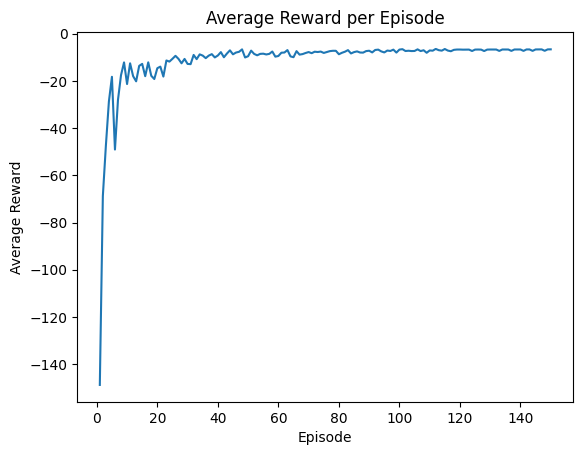

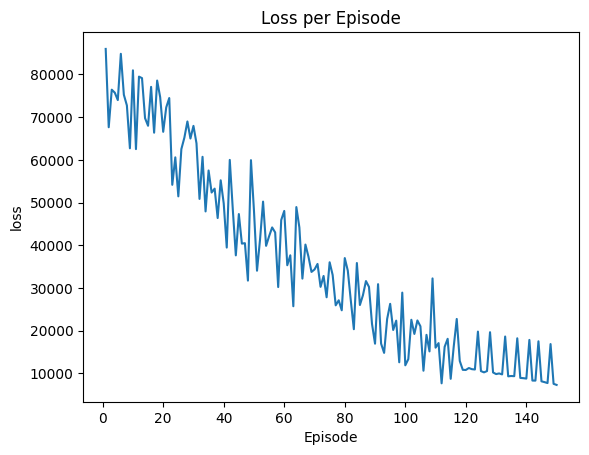

In [608]:
# For optimal stopping (random episode)
# max_episodes 만큼 반복.
average_rewards = []
training_loss = []
best_average_reward = -10000

# parameter of random episode
size_of_t_replace = environment['unit_number'].max() - 1 # unit98이 마지막이면, unit99가 다음
min_t_replace = 1
max_t_replace = 200

for episode in range(max_episodes):

    replace_failure = 0  # each episode 마다 초기화. 누적시킬 필요는 없음.
    state_index = 0      # state index -> index pointer로 취급하자. (episode 마다 초기화)
    total_reward = 0
    num_of_step = 0
    loss_episode = 0

    # cum_total_reward <- 이게 필요한가? reward는 각 episode별로 알면 끝인가? 아마 맞는듯. (나중에 다시 체크)

    # 이 맨 밖의 for문이 이상함. 이거 해결하자. (지금은 아래의 학습 과정이 이 for문만큼 실행됨.)
    # 하나의 episode는 전체 엔진을 모두 사용할 때까지!
    for unit_num in range(max_unit_number):  # unit num : 0, .... , (max_unit_number - 1)
        state = states.iloc[state_index].values

       # decay epsilon (linear)
        epsilon = max(min_epsilon, initial_epsilon - episode * epsilon_delta) # epsilon decay는 episode에 따라 감소해야함.

        # random episode를 위한 조건 분기
        if np.random.rand() < epsilon:
          # unit 수 만큼, uniform distribution에서 t_replace을 뽑기 (시작부터 에피소드 내의 모든 t_replace 결정)
          # 마지막 unit 이후의 action도 알아야 하므로, greedy-Action을 하는 반복문보다 unit을 하나 더 앞까지 보자.
          t_replace = [random.randint(min_t_replace, max_t_replace) for _ in range(size_of_t_replace)]

          # out of bound 문제를 막기 위해 '최대 unit number - 1'의 끝에 도달하면 멈추게 함. 데이터에 마지막 더미 row를 추가해서, 원본 데이터를 모두 활용할 수 있도록 수정하자.
          while (state_index < environment[environment['unit_number'] == (environment['unit_number'].max() - 2)].index[-1] + 1) and environment['unit_number'].iloc[state_index] == (unit_num + 1):
            current_state = state

            # t_replace[unit_number - 1] 이하면 continue. stateMinIndex func을 통해 state_index가 해당되는 unit의 최소 index를 가져옴.
            if state_index < ( stateMinIndex(state_index) + t_replace[environment['unit_number'].iloc[state_index] - 1] ):
              chosen_action = 'continue'
            else:
              chosen_action = 'replace'

            next_state_index = nextStateIndex(chosen_action, state_index)
            next_state = states.iloc[next_state_index].values # S_{t+1}

            current_reward = calculateReward(state_index, next_state_index, chosen_action)

            # count 'replace failure'
            if current_reward == (-10000):
              replace_failure += 1

            # next action
            if next_state_index < stateMinIndex(next_state_index) + t_replace[environment['unit_number'].iloc[next_state_index] - 1]:
              next_chosen_action = 'continue'
            else:
              next_chosen_action = 'replace'

            # update q-value (Linear Function Approximation)
            #next_state_q = np.dot(weights[next_chosen_action], next_state)    # A' ~ random generated episode
            next_state_q = calculateQ(next_chosen_action, next_state)
            #current_state_q = np.dot(weights[chosen_action], current_state)   # A  ~ random generated episode
            current_state_q = calculateQ(chosen_action, current_state)

            # TD target, weight
            TD_target = current_reward + gamma * next_state_q

            if chosen_action == 'continue':
              delta_w = alpha * (TD_target - current_state_q) * current_state
            else:
              delta_w = alpha * (TD_target - current_state_q) * current_state[0] # s_0만 빼옴

            weights[chosen_action] = weights[chosen_action] + delta_w

            # 총 리워드 업데이트
            total_reward += current_reward
            loss_episode += TD_target - current_state_q

            # 다음 상태로 이동
            state_index = next_state_index
            state = states.iloc[state_index].values
            num_of_step += 1

        # random episode가 아닌 경우, greedy action 수행.
        else:
          while (state_index < environment[environment['unit_number'] == (environment['unit_number'].max() - 2)].index[-1] + 1) and environment['unit_number'].iloc[state_index] == (unit_num + 1):
            current_state = state

            #chosen_action = max(actions, key=lambda a: np.dot(weights[a], current_state)) # greedy action
            chosen_action = getGreedyAction(current_state)
            next_state_index = nextStateIndex(chosen_action, state_index)
            next_state = states.iloc[next_state_index].values # S_{t+1}

            current_reward = calculateReward(state_index, next_state_index, chosen_action)

            # count 'replace failure'
            if current_reward == (-10000):
                replace_failure += 1

            # update q-value (Linear Function Approximation)
            #next_state_q = max([np.dot(weights[a], next_state) for a in actions])  # A' ~ greedy action
            next_state_q = calculateQ(getGreedyAction(next_state), next_state)
            #current_state_q = np.dot(weights[chosen_action], current_state)        # A  ~ greedy action
            current_state_q = calculateQ(chosen_action, current_state)

            TD_target = current_reward + gamma * next_state_q

            if chosen_action == 'continue':
              delta_w = alpha * (TD_target - current_state_q) * current_state
            else:
              delta_w = alpha * (TD_target - current_state_q) * current_state[0] # s_0만 빼옴

            weights[chosen_action] = weights[chosen_action] + delta_w

            # 총 리워드 업데이트
            total_reward += current_reward

            # episode 내에서의 loss 누적
            loss_episode += TD_target - current_state_q

            # 다음 상태로 이동
            state_index = next_state_index
            state = states.iloc[state_index].values
            num_of_step += 1


    # episode 학습 결과 출력
    average_reward = total_reward / num_of_step

    # best weight 저장
    if average_reward > best_average_reward:
      best_average_reward = copy(average_reward)
      best_weights = copy(weights)

    average_rewards.append(average_reward)
    training_loss.append(np.abs(loss_episode))
    print(f"episode : {episode + 1}, replace failure : {replace_failure}, Average Reward : {average_reward}, loss : {np.abs(loss_episode)}")


# episode에 따른 average reward
plt.plot(range(1, max_episodes + 1), average_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode')
plt.show()

# loss plot
plt.plot(range(1, max_episodes + 1), training_loss)
plt.xlabel('Episode')
plt.ylabel('loss')
plt.title('Loss per Episode')
plt.show()

In [609]:
print(weights['continue'])

[-3.74874473e+03 -3.73659091e-01 -2.45644415e+02 -1.90091857e+02
 -4.23717234e+02 -6.40745938e-01 -6.52001059e+02 -3.76421419e+02
 -4.02907485e+02 -5.60341522e+02 -4.77247220e+02 -5.98671874e+02
 -5.43976738e+02 -3.60934767e+02 -4.03231108e+02 -3.45079200e+02
 -1.04737468e+00 -1.66963057e+02 -7.17070331e-01 -1.39114349e-01
  1.45141200e+02  1.30182291e+02]


In [610]:
print(weights['replace'])

[-6978.02199628]


In [611]:
print(best_weights['continue'])

[-3.00563797e+03 -3.73659091e-01 -2.71596197e+02 -2.03625762e+02
 -4.47157174e+02 -6.40745938e-01 -9.62970795e+02 -4.96881037e+02
 -4.44689482e+02 -5.81234489e+02 -5.77599627e+02 -6.34515810e+02
 -6.06558324e+02 -3.99121839e+02 -4.88699440e+02 -4.12050813e+02
 -1.04737468e+00 -1.71465101e+02 -7.17070331e-01 -1.39114349e-01
  1.02853157e+02  7.90733016e+01]


In [612]:
print(best_weights['replace'])

[-6804.85729691]


**학습된 Q로 전체 데이터에 대해 성능 테스트**

In [613]:
# 함수 뒤에 dataset을 입력으로 받아서 train 함수와 동일하게 사용하자.

In [614]:
full_data

unit_number  time_cycles  setting_1  setting_2  setting_3  s_0  s_1  \
0                1            1    -0.0005     0.0004      100.0    1  0.0   
1                1            2     0.0008    -0.0003      100.0    1  0.0   
2                1            3    -0.0014    -0.0002      100.0    1  0.0   
3                1            4    -0.0020     0.0001      100.0    1  0.0   
4                1            5     0.0016     0.0000      100.0    1  0.0   
...            ...          ...        ...        ...        ...  ...  ...   
24715          100          148    -0.0016    -0.0003      100.0    1  0.0   
24716          100          149     0.0034    -0.0003      100.0    1  0.0   
24717          100          150    -0.0016     0.0004      100.0    1  0.0   
24718          100          151    -0.0023     0.0004      100.0    1  0.0   
24719          100          152     0.0000     0.0003      100.0    1  0.0   

            s_2       s_3       s_4  ...      s_13      s_14      s_15  s_16  \
0      0.355972  0.370523  0.308580  ...  0.642857  0.239116  0.647755   0.0   
1      0.388759  0.399100  0.309360  ...  0.654762  0.278567  0.685659   0.0   
2      0.313817  0.353298  0.445398  ...  0.636905  0.264526  0.564462   0.0   
3      0.487119  0.417107  0.237285  ...  0.684524  0.245612  0.558909   0.0   
4      0.196721  0.476218  0.321217  ...  0.654762  0.252109  0.556736   0.0   
...         ...       ...       ...  ...       ...       ...       ...   ...   
24715  0.688525  0.620669  0.734009  ...  0.815476  0.201184  0.838484   0.0   
24716  0.573770  0.627912  0.812480  ...  0.803571  0.234086  0.871801   0.0   
24717  0.702576  0.787434  0.847894  ...  0.779762  0.190025  0.883631   0.0   
24718  0.725995  0.651008  0.772387  ...  0.791667  0.217740  0.865524   0.0   
24719  0.655738  0.679977  0.920437  ...  0.779762  0.195421  0.866007   0.0   

           s_17  s_18  s_19      s_20      s_21  RUL  
0      0.272727   0.0   0.0  0.559524  0.446331  258  
1      0.363636   0.0   0.0  0.488095  0.534836  257  
2      0.272727   0.0   0.0  0.404762  0.458577  256  
3      0.363636   0.0   0.0  0.470238  0.391966  255  
4      0.363636   0.0   0.0  0.577381  0.543371  254  
...         ...   ...   ...       ...       ...  ...  
24715  0.545455   0.0   0.0  0.160714  0.083960    4  
24716  0.636364   0.0   0.0  0.196429  0.094628    3  
24717  0.727273   0.0   0.0  0.130952  0.181464    2  
24718  0.636364   0.0   0.0  0.083333  0.188051    1  
24719  0.727273   0.0   0.0  0.232143  0.196772    0  

[24720 rows x 28 columns]

In [615]:
environment_test = full_data
states_test = environment_test[['s_{}'.format(i) for i in range(0, 22)]]

In [616]:
def calculateRewardTest(current_index, next_index, action):
    # 'unit_number' 열의 현재 및 다음 행 값 추출
    current_unit_number = environment_test['unit_number'].iloc[current_index]
    next_unit_number = environment_test['unit_number'].iloc[next_index]

    if action == 'continue':
        # 다음 'unit_number'가 바뀌지 않으면 0 (next state가 failure가 아님)
        if current_unit_number == next_unit_number:
          return r_continue
        # 다음 'unit_number'가 바뀌면 -10,000 (next state가 failure; replace 실패에 해당)
        else:
          return r_continue_but_failure
    elif action == 'replace':
      # 'Replace' 액션을 취한 경우, 다음 'unit_number'로 교체됨
      # 이 경우, 다음 'unit_number'가 1로 초기화되므로 -1,000의 보상을 줄 수 있음
      return r_replace

In [617]:
def nextStateIndexTest(action, current_index):
  # action에 따라 next state가 달라짐.
  if action == 'continue':
    return current_index + 1
  else:
    # replace인 경우 next_state는 다음 엔진(unit_number)의 첫번째 행.
    current_unit_number = environment_test['unit_number'].iloc[current_index]
    next_unit_initial_index = environment_test[environment_test['unit_number'] == current_unit_number].index[-1] + 1
    return next_unit_initial_index

**Q_replace를 상수로 쓰기 위한 함수 추가**

In [618]:
def getGreedyActionTest(state):
  temp_q_continue = np.dot(best_weights['continue'], state)
  temp_q_replace = best_weights['replace'] * state[0]
  if temp_q_continue >= temp_q_replace:
    return 'continue'
  else:
    return 'replace'

In [619]:
max_unit_number = environment_test['unit_number'].max() # 마지막 unit_number를 return. (1~70이라면 70 반환)
replace_failure = 0
state_index = 0      # state index -> index pointer로 취급.
total_reward = 0
num_of_step = 0
average_rewards = 0
average_usage_time = 0

for unit_num in range(max_unit_number):  # unit num : 0, .... , (max_unit_number - 1)
    state = states_test.iloc[state_index].values

    # out of bound 문제를 막기 위해 '최대 unit number - 1'의 끝에 도달하면 멈추게 함. 데이터에 마지막 더미 row를 추가해서, 원본 데이터를 모두 활용할 수 있도록 수정하자.
    while (state_index < environment_test[environment_test['unit_number'] == (environment_test['unit_number'].max() - 2)].index[-1] + 1) and environment_test['unit_number'].iloc[state_index] == (unit_num + 1):
        current_state = state

        #chosen_action = max(actions, key=lambda a: np.dot(best_weights[a], current_state))
        chosen_action = getGreedyActionTest(current_state)

        next_state_index = nextStateIndexTest(chosen_action, state_index)
        next_state = states_test.iloc[next_state_index].values # S_{t+1}
        current_reward = calculateRewardTest(state_index, next_state_index, chosen_action)

        # count 'replace failure'
        if current_reward == (-10000):
            replace_failure += 1
            #print(replace_failure)

        # 총 리워드 업데이트
        total_reward += current_reward

        # 다음 상태로 이동
        state_index = next_state_index
        state = states_test.iloc[state_index].values
        num_of_step += 1

# episode 학습 결과 출력
average_reward = total_reward / num_of_step
average_usage_time = num_of_step / (environment_test['unit_number'].max() - 2)
print(f"Number of Engine : {environment_test['unit_number'].max() - 2}, Average Reward : {average_reward}, replace failure : {replace_failure}, average usage time : {average_usage_time}")
#print(np.dot(weights['continue'], states_test.iloc[state_index].values))
#print(np.dot(weights['replace'], states_test.iloc[state_index].values))

Number of Engine : 98, Average Reward : -6.911918512118594, replace failure : 6, average usage time : 224.39795918367346


# Q-value를 remaining useful life (RUL) prediction으로 convert

Best weights 가져오기

In [620]:
save_weights = copy(best_weights)
print(save_weights)

{'continue': array([-3.00563797e+03, -3.73659091e-01, -2.71596197e+02, -2.03625762e+02,
       -4.47157174e+02, -6.40745938e-01, -9.62970795e+02, -4.96881037e+02,
       -4.44689482e+02, -5.81234489e+02, -5.77599627e+02, -6.34515810e+02,
       -6.06558324e+02, -3.99121839e+02, -4.88699440e+02, -4.12050813e+02,
       -1.04737468e+00, -1.71465101e+02, -7.17070331e-01, -1.39114349e-01,
        1.02853157e+02,  7.90733016e+01]), 'replace': array([-6804.85729691])}


**Q_repalce를 상수로 쓰기 위한 함수**

In [621]:
def getGreedyActionSave(state):
  temp_q_continue = np.dot(save_weights['continue'], state)
  temp_q_replace = save_weights['replace'] * state[0]
  if temp_q_continue >= temp_q_replace:
    return 'continue'
  else:
    return 'replace'

In [622]:
max_unit_number = environment_test['unit_number'].max() # 마지막 unit_number를 return. (1~70이라면 70 반환)
replace_failure = 0
state_index = 0      # state index -> index pointer로 취급.
total_reward = 0
num_of_step = 0
average_rewards = 0
average_usage_time = 0
replace_indices = []   # replace가 발생한 index를 저장하기 위한 배열 (이 배열을 이용해서 Replace가 발생할 때의 q-value를 알 수 있음)

for unit_num in range(max_unit_number):  # unit num : 0, .... , (max_unit_number - 1)
    state = states_test.iloc[state_index].values

    # out of bound 문제를 막기 위해 '최대 unit number - 1'의 끝에 도달하면 멈추게 함. 데이터에 마지막 더미 row를 추가해서, 원본 데이터를 모두 활용할 수 있도록 수정하자.
    while (state_index < environment_test[environment_test['unit_number'] == (environment_test['unit_number'].max() - 2)].index[-1] + 1) and environment_test['unit_number'].iloc[state_index] == (unit_num + 1):
        current_state = state

        #chosen_action = max(actions, key=lambda a: np.dot(save_weights[a], current_state))
        chosen_action = getGreedyActionSave(current_state)

        next_state_index = nextStateIndexTest(chosen_action, state_index)
        next_state = states_test.iloc[next_state_index].values # S_{t+1}
        current_reward = calculateRewardTest(state_index, next_state_index, chosen_action)

        # count 'replace failure'
        if current_reward == (-10000):
          replace_failure += 1
          print(replace_failure)
          print(state_index)

        # 총 리워드 업데이트
        total_reward += current_reward

        # next state로 가기 전에, action이 replace인 state를 저장.
        if(chosen_action == 'replace'):
          replace_indices.append(state_index)
          #print("saved")


        # 다음 상태로 이동
        state_index = next_state_index
        state = states_test.iloc[state_index].values
        num_of_step += 1

# episode 학습 결과 출력
average_reward = total_reward / num_of_step
average_usage_time = num_of_step / (environment_test['unit_number'].max() - 2)
print(f"Number of Engine : {environment_test['unit_number'].max() - 2}, Average Reward : {average_reward}, replace failure : {replace_failure}, average usage time : {average_usage_time}")
#print(np.dot(weights['continue'], states_test.iloc[state_index].values))
#print(np.dot(weights['replace'], states_test.iloc[state_index].values))
print(replace_indices)

1
3074
2
14963
3
18989
4
19631
5
19778
6
22791
Number of Engine : 98, Average Reward : -6.911918512118594, replace failure : 6, average usage time : 224.39795918367346
[239, 481, 719, 996, 1195, 1484, 1873, 2176, 2489, 3256, 3431, 3599, 3832, 4014, 4315, 4658, 5104, 5308, 5655, 5896, 6107, 6306, 6762, 6978, 7233, 7532, 7756, 7981, 8179, 8384, 8554, 8772, 9216, 9481, 9821, 10109, 10310, 10587, 10820, 11071, 11292, 11583, 11805, 11992, 12193, 12462, 12645, 12873, 13080, 13251, 13475, 13655, 13830, 14322, 14570, 14744, 15187, 15427, 15624, 15870, 16120, 16302, 16557, 16714, 16973, 17161, 17352, 17522, 17911, 18140, 18363, 18555, 18813, 19193, 19448, 20087, 20355, 20582, 20788, 21029, 21389, 21581, 21884, 22101, 22295, 22458, 22618, 23078, 23329, 23787, 24071, 24381]


**Q(Continue - Replace)를 위한 weights 수정 (s_0 version)**

In [623]:
c_threshold = -1
slicing_index = 0  # 1번째 값 (s_0)을 슬라이싱으로 제거하기 위한 index.

save_weights['continue'][0] -= save_weights["replace"] # w_0의 값에만 replace에 대한 constant를 빼줌.
weights_difference = np.array(save_weights["continue"])
weights_difference

array([ 3.79921933e+03, -3.73659091e-01, -2.71596197e+02, -2.03625762e+02,
       -4.47157174e+02, -6.40745938e-01, -9.62970795e+02, -4.96881037e+02,
       -4.44689482e+02, -5.81234489e+02, -5.77599627e+02, -6.34515810e+02,
       -6.06558324e+02, -3.99121839e+02, -4.88699440e+02, -4.12050813e+02,
       -1.04737468e+00, -1.71465101e+02, -7.17070331e-01, -1.39114349e-01,
        1.02853157e+02,  7.90733016e+01])

In [624]:
save_weights['continue'][0]

3799.2193287820874

In [625]:
best_weights['continue'][0]

3799.2193287820874

**State 중 constant인 index에 대응되는 weights의 index 추출.**

In [626]:
weights_constant = weights_difference[slicing_index] # (slicing_index + 1)의 값을 저장. (나중에 나누기 위함)
weights_difference = np.delete(weights_difference, slicing_index) # (slicing_index + 1)의 값을 슬라이싱으로 제거.
print(weights_constant)
print(weights_difference)

3799.2193287820874
[-3.73659091e-01 -2.71596197e+02 -2.03625762e+02 -4.47157174e+02
 -6.40745938e-01 -9.62970795e+02 -4.96881037e+02 -4.44689482e+02
 -5.81234489e+02 -5.77599627e+02 -6.34515810e+02 -6.06558324e+02
 -3.99121839e+02 -4.88699440e+02 -4.12050813e+02 -1.04737468e+00
 -1.71465101e+02 -7.17070331e-01 -1.39114349e-01  1.02853157e+02
  7.90733016e+01]


In [627]:
print(best_weights)

{'continue': array([ 3.79921933e+03, -3.73659091e-01, -2.71596197e+02, -2.03625762e+02,
       -4.47157174e+02, -6.40745938e-01, -9.62970795e+02, -4.96881037e+02,
       -4.44689482e+02, -5.81234489e+02, -5.77599627e+02, -6.34515810e+02,
       -6.06558324e+02, -3.99121839e+02, -4.88699440e+02, -4.12050813e+02,
       -1.04737468e+00, -1.71465101e+02, -7.17070331e-01, -1.39114349e-01,
        1.02853157e+02,  7.90733016e+01]), 'replace': array([-6804.85729691])}


**Weights에 (C / (- w_0))' 곱하기**

In [628]:
temp = ( c_threshold / (-weights_constant) )
print(temp)

0.0002632119689495708


In [629]:
weights_difference *= temp
print(weights_difference)

[-9.83515450e-05 -7.14873698e-02 -5.35967378e-02 -1.17697120e-01
 -1.68652000e-04 -2.53465439e-01 -1.30785036e-01 -1.17047594e-01
 -1.52987874e-01 -1.52031135e-01 -1.67012156e-01 -1.59653411e-01
 -1.05053645e-01 -1.28631542e-01 -1.08456706e-01 -2.75681553e-04
 -4.51316667e-02 -1.88741494e-04 -3.66165616e-05  2.70721819e-02
  2.08130394e-02]


In [630]:
RL_results = copy(states_test)
RL_results

s_0  s_1       s_2       s_3       s_4  s_5  s_6       s_7       s_8  \
0        1  0.0  0.355972  0.370523  0.308580  0.0  1.0  0.208812  0.623529   
1        1  0.0  0.388759  0.399100  0.309360  0.0  1.0  0.236590  0.647059   
2        1  0.0  0.313817  0.353298  0.445398  0.0  1.0  0.230843  0.664706   
3        1  0.0  0.487119  0.417107  0.237285  0.0  1.0  0.268199  0.647059   
4        1  0.0  0.196721  0.476218  0.321217  0.0  1.0  0.245690  0.670588   
...    ...  ...       ...       ...       ...  ...  ...       ...       ...   
24715    1  0.0  0.688525  0.620669  0.734009  0.0  1.0  0.107759  0.794118   
24716    1  0.0  0.573770  0.627912  0.812480  0.0  1.0  0.107759  0.782353   
24717    1  0.0  0.702576  0.787434  0.847894  0.0  1.0  0.080939  0.794118   
24718    1  0.0  0.725995  0.651008  0.772387  0.0  1.0  0.051724  0.800000   
24719    1  0.0  0.655738  0.679977  0.920437  0.0  1.0  0.064655  0.800000   

            s_9  ...      s_12      s_13      s_14      s_15  s_16      s_17  \
0      0.204233  ...  0.231279  0.642857  0.239116  0.647755   0.0  0.272727   
1      0.202431  ...  0.236882  0.654762  0.278567  0.685659   0.0  0.363636   
2      0.241484  ...  0.217015  0.636905  0.264526  0.564462   0.0  0.272727   
3      0.215326  ...  0.240448  0.684524  0.245612  0.558909   0.0  0.363636   
4      0.268799  ...  0.245033  0.654762  0.252109  0.556736   0.0  0.363636   
...         ...  ...       ...       ...       ...       ...   ...       ...   
24715  0.244211  ...  0.096281  0.815476  0.201184  0.838484   0.0  0.545455   
24716  0.215464  ...  0.109017  0.803571  0.234086  0.871801   0.0  0.636364   
24717  0.210149  ...  0.085074  0.779762  0.190025  0.883631   0.0  0.727273   
24718  0.204465  ...  0.114111  0.791667  0.217740  0.865524   0.0  0.636364   
24719  0.224338  ...  0.087112  0.779762  0.195421  0.866007   0.0  0.727273   

       s_18  s_19      s_20      s_21  
0       0.0   0.0  0.559524  0.446331  
1       0.0   0.0  0.488095  0.534836  
2       0.0   0.0  0.404762  0.458577  
3       0.0   0.0  0.470238  0.391966  
4       0.0   0.0  0.577381  0.543371  
...     ...   ...       ...       ...  
24715   0.0   0.0  0.160714  0.083960  
24716   0.0   0.0  0.196429  0.094628  
24717   0.0   0.0  0.130952  0.181464  
24718   0.0   0.0  0.083333  0.188051  
24719   0.0   0.0  0.232143  0.196772  

[24720 rows x 22 columns]

**Q_continue, Q_replace를 추가**

In [631]:
best_weights['continue'][0] += best_weights["replace"]

In [632]:
best_weights['continue']

array([-3.00563797e+03, -3.73659091e-01, -2.71596197e+02, -2.03625762e+02,
       -4.47157174e+02, -6.40745938e-01, -9.62970795e+02, -4.96881037e+02,
       -4.44689482e+02, -5.81234489e+02, -5.77599627e+02, -6.34515810e+02,
       -6.06558324e+02, -3.99121839e+02, -4.88699440e+02, -4.12050813e+02,
       -1.04737468e+00, -1.71465101e+02, -7.17070331e-01, -1.39114349e-01,
        1.02853157e+02,  7.90733016e+01])

In [633]:
weights_difference

array([-9.83515450e-05, -7.14873698e-02, -5.35967378e-02, -1.17697120e-01,
       -1.68652000e-04, -2.53465439e-01, -1.30785036e-01, -1.17047594e-01,
       -1.52987874e-01, -1.52031135e-01, -1.67012156e-01, -1.59653411e-01,
       -1.05053645e-01, -1.28631542e-01, -1.08456706e-01, -2.75681553e-04,
       -4.51316667e-02, -1.88741494e-04, -3.66165616e-05,  2.70721819e-02,
        2.08130394e-02])

In [634]:
# 두번째 RL_results를 S_0이 포함된 데이터로 바꿔야함.
#RL_results['Q-continue'] = RL_results.iloc[:, :-1].apply(lambda row: np.dot(best_weights['continue'], row), axis=1)
RL_results['Q-continue'] = RL_results.apply(lambda row: np.dot(best_weights['continue'], row), axis=1)
RL_results

s_0  s_1       s_2       s_3       s_4  s_5  s_6       s_7       s_8  \
0        1  0.0  0.355972  0.370523  0.308580  0.0  1.0  0.208812  0.623529   
1        1  0.0  0.388759  0.399100  0.309360  0.0  1.0  0.236590  0.647059   
2        1  0.0  0.313817  0.353298  0.445398  0.0  1.0  0.230843  0.664706   
3        1  0.0  0.487119  0.417107  0.237285  0.0  1.0  0.268199  0.647059   
4        1  0.0  0.196721  0.476218  0.321217  0.0  1.0  0.245690  0.670588   
...    ...  ...       ...       ...       ...  ...  ...       ...       ...   
24715    1  0.0  0.688525  0.620669  0.734009  0.0  1.0  0.107759  0.794118   
24716    1  0.0  0.573770  0.627912  0.812480  0.0  1.0  0.107759  0.782353   
24717    1  0.0  0.702576  0.787434  0.847894  0.0  1.0  0.080939  0.794118   
24718    1  0.0  0.725995  0.651008  0.772387  0.0  1.0  0.051724  0.800000   
24719    1  0.0  0.655738  0.679977  0.920437  0.0  1.0  0.064655  0.800000   

            s_9  ...      s_13      s_14      s_15  s_16      s_17  s_18  \
0      0.204233  ...  0.642857  0.239116  0.647755   0.0  0.272727   0.0   
1      0.202431  ...  0.654762  0.278567  0.685659   0.0  0.363636   0.0   
2      0.241484  ...  0.636905  0.264526  0.564462   0.0  0.272727   0.0   
3      0.215326  ...  0.684524  0.245612  0.558909   0.0  0.363636   0.0   
4      0.268799  ...  0.654762  0.252109  0.556736   0.0  0.363636   0.0   
...         ...  ...       ...       ...       ...   ...       ...   ...   
24715  0.244211  ...  0.815476  0.201184  0.838484   0.0  0.545455   0.0   
24716  0.215464  ...  0.803571  0.234086  0.871801   0.0  0.636364   0.0   
24717  0.210149  ...  0.779762  0.190025  0.883631   0.0  0.727273   0.0   
24718  0.204465  ...  0.791667  0.217740  0.865524   0.0  0.636364   0.0   
24719  0.224338  ...  0.779762  0.195421  0.866007   0.0  0.727273   0.0   

       s_19      s_20      s_21   Q-continue  
0       0.0  0.559524  0.446331 -5926.715315  
1       0.0  0.488095  0.534836 -5998.609729  
2       0.0  0.404762  0.458577 -5976.859007  
3       0.0  0.470238  0.391966 -5982.431797  
4       0.0  0.577381  0.543371 -5921.044571  
...     ...       ...       ...          ...  
24715   0.0  0.160714  0.083960 -6822.293094  
24716   0.0  0.196429  0.094628 -6798.840043  
24717   0.0  0.130952  0.181464 -6863.858402  
24718   0.0  0.083333  0.188051 -6763.572387  
24719   0.0  0.232143  0.196772 -6827.704075  

[24720 rows x 23 columns]

In [635]:
"""
RL_results['Q-replace'] = RL_results.iloc[:, :-1].apply(lambda row: np.dot(best_weights['replace'], row), axis=1)
RL_results
"""

"\nRL_results['Q-replace'] = RL_results.iloc[:, :-1].apply(lambda row: np.dot(best_weights['replace'], row), axis=1)\nRL_results\n"

**s_0 drop!**

In [636]:
RL_results = RL_results.drop('s_0', axis=1)
RL_results

s_1       s_2       s_3       s_4  s_5  s_6       s_7       s_8  \
0      0.0  0.355972  0.370523  0.308580  0.0  1.0  0.208812  0.623529   
1      0.0  0.388759  0.399100  0.309360  0.0  1.0  0.236590  0.647059   
2      0.0  0.313817  0.353298  0.445398  0.0  1.0  0.230843  0.664706   
3      0.0  0.487119  0.417107  0.237285  0.0  1.0  0.268199  0.647059   
4      0.0  0.196721  0.476218  0.321217  0.0  1.0  0.245690  0.670588   
...    ...       ...       ...       ...  ...  ...       ...       ...   
24715  0.0  0.688525  0.620669  0.734009  0.0  1.0  0.107759  0.794118   
24716  0.0  0.573770  0.627912  0.812480  0.0  1.0  0.107759  0.782353   
24717  0.0  0.702576  0.787434  0.847894  0.0  1.0  0.080939  0.794118   
24718  0.0  0.725995  0.651008  0.772387  0.0  1.0  0.051724  0.800000   
24719  0.0  0.655738  0.679977  0.920437  0.0  1.0  0.064655  0.800000   

            s_9      s_10  ...      s_13      s_14      s_15  s_16      s_17  \
0      0.204233  0.333333  ...  0.642857  0.239116  0.647755   0.0  0.272727   
1      0.202431  0.333333  ...  0.654762  0.278567  0.685659   0.0  0.363636   
2      0.241484  0.333333  ...  0.636905  0.264526  0.564462   0.0  0.272727   
3      0.215326  0.333333  ...  0.684524  0.245612  0.558909   0.0  0.363636   
4      0.268799  0.333333  ...  0.654762  0.252109  0.556736   0.0  0.363636   
...         ...       ...  ...       ...       ...       ...   ...       ...   
24715  0.244211  0.333333  ...  0.815476  0.201184  0.838484   0.0  0.545455   
24716  0.215464  0.333333  ...  0.803571  0.234086  0.871801   0.0  0.636364   
24717  0.210149  0.333333  ...  0.779762  0.190025  0.883631   0.0  0.727273   
24718  0.204465  0.333333  ...  0.791667  0.217740  0.865524   0.0  0.636364   
24719  0.224338  0.333333  ...  0.779762  0.195421  0.866007   0.0  0.727273   

       s_18  s_19      s_20      s_21   Q-continue  
0       0.0   0.0  0.559524  0.446331 -5926.715315  
1       0.0   0.0  0.488095  0.534836 -5998.609729  
2       0.0   0.0  0.404762  0.458577 -5976.859007  
3       0.0   0.0  0.470238  0.391966 -5982.431797  
4       0.0   0.0  0.577381  0.543371 -5921.044571  
...     ...   ...       ...       ...          ...  
24715   0.0   0.0  0.160714  0.083960 -6822.293094  
24716   0.0   0.0  0.196429  0.094628 -6798.840043  
24717   0.0   0.0  0.130952  0.181464 -6863.858402  
24718   0.0   0.0  0.083333  0.188051 -6763.572387  
24719   0.0   0.0  0.232143  0.196772 -6827.704075  

[24720 rows x 22 columns]

**Weights를 바탕으로 RUL_prediction (Q-value의 weight으로)**

In [637]:
weights_difference

array([-9.83515450e-05, -7.14873698e-02, -5.35967378e-02, -1.17697120e-01,
       -1.68652000e-04, -2.53465439e-01, -1.30785036e-01, -1.17047594e-01,
       -1.52987874e-01, -1.52031135e-01, -1.67012156e-01, -1.59653411e-01,
       -1.05053645e-01, -1.28631542e-01, -1.08456706e-01, -2.75681553e-04,
       -4.51316667e-02, -1.88741494e-04, -3.66165616e-05,  2.70721819e-02,
        2.08130394e-02])

In [638]:
RL_results['predicted RUL'] = RL_results.iloc[:, :-1].apply(lambda row: np.dot(weights_difference, row), axis=1) # Q-continue, Q-replace 무시
RL_results

s_1       s_2       s_3       s_4  s_5  s_6       s_7       s_8  \
0      0.0  0.355972  0.370523  0.308580  0.0  1.0  0.208812  0.623529   
1      0.0  0.388759  0.399100  0.309360  0.0  1.0  0.236590  0.647059   
2      0.0  0.313817  0.353298  0.445398  0.0  1.0  0.230843  0.664706   
3      0.0  0.487119  0.417107  0.237285  0.0  1.0  0.268199  0.647059   
4      0.0  0.196721  0.476218  0.321217  0.0  1.0  0.245690  0.670588   
...    ...       ...       ...       ...  ...  ...       ...       ...   
24715  0.0  0.688525  0.620669  0.734009  0.0  1.0  0.107759  0.794118   
24716  0.0  0.573770  0.627912  0.812480  0.0  1.0  0.107759  0.782353   
24717  0.0  0.702576  0.787434  0.847894  0.0  1.0  0.080939  0.794118   
24718  0.0  0.725995  0.651008  0.772387  0.0  1.0  0.051724  0.800000   
24719  0.0  0.655738  0.679977  0.920437  0.0  1.0  0.064655  0.800000   

            s_9      s_10  ...      s_14      s_15  s_16      s_17  s_18  \
0      0.204233  0.333333  ...  0.239116  0.647755   0.0  0.272727   0.0   
1      0.202431  0.333333  ...  0.278567  0.685659   0.0  0.363636   0.0   
2      0.241484  0.333333  ...  0.264526  0.564462   0.0  0.272727   0.0   
3      0.215326  0.333333  ...  0.245612  0.558909   0.0  0.363636   0.0   
4      0.268799  0.333333  ...  0.252109  0.556736   0.0  0.363636   0.0   
...         ...       ...  ...       ...       ...   ...       ...   ...   
24715  0.244211  0.333333  ...  0.201184  0.838484   0.0  0.545455   0.0   
24716  0.215464  0.333333  ...  0.234086  0.871801   0.0  0.636364   0.0   
24717  0.210149  0.333333  ...  0.190025  0.883631   0.0  0.727273   0.0   
24718  0.204465  0.333333  ...  0.217740  0.865524   0.0  0.636364   0.0   
24719  0.224338  0.333333  ...  0.195421  0.866007   0.0  0.727273   0.0   

       s_19      s_20      s_21   Q-continue  predicted RUL  
0       0.0  0.559524  0.446331 -5926.715315      -0.768863  
1       0.0  0.488095  0.534836 -5998.609729      -0.787786  
2       0.0  0.404762  0.458577 -5976.859007      -0.782061  
3       0.0  0.470238  0.391966 -5982.431797      -0.783528  
4       0.0  0.577381  0.543371 -5921.044571      -0.767370  
...     ...       ...       ...          ...            ...  
24715   0.0  0.160714  0.083960 -6822.293094      -1.004589  
24716   0.0  0.196429  0.094628 -6798.840043      -0.998416  
24717   0.0  0.130952  0.181464 -6863.858402      -1.015530  
24718   0.0  0.083333  0.188051 -6763.572387      -0.989133  
24719   0.0  0.232143  0.196772 -6827.704075      -1.006014  

[24720 rows x 23 columns]

In [639]:
# s_1~s_21로 Q-value를 구하는 코드
"""
continue_weights = copy(save_weights["continue"])
replace_weights = copy(save_weights["replace"])

continue_weights = np.delete(continue_weights, slicing_index)
replace_weights = np.delete(replace_weights, slicing_index)
print(continue_weights)
print(replace_weights)
"""

'\ncontinue_weights = copy(save_weights["continue"])\nreplace_weights = copy(save_weights["replace"])\n\ncontinue_weights = np.delete(continue_weights, slicing_index)\nreplace_weights = np.delete(replace_weights, slicing_index)\nprint(continue_weights)\nprint(replace_weights)\n'

**Replace가 발생했을 때의 RUL prediction 값을 출력 (dummy_state_value를 조정해 threshold와 맞추기 위해)**

In [640]:
for index in replace_indices:
    rul_prediction = RL_results.loc[index, 'predicted RUL']
    print(f'Index {index}: predicted RUL = {rul_prediction}')

Index 239: predicted RUL = -1.0060262900459673
Index 481: predicted RUL = -1.0113852448992318
Index 719: predicted RUL = -1.0089012285317305
Index 996: predicted RUL = -1.0012177816354948
Index 1195: predicted RUL = -1.0016858767890373
Index 1484: predicted RUL = -1.0032032589769426
Index 1873: predicted RUL = -1.002814139386561
Index 2176: predicted RUL = -1.003180516629767
Index 2489: predicted RUL = -1.0044196861722952
Index 3256: predicted RUL = -1.0619725714608137
Index 3431: predicted RUL = -1.0007658324234552
Index 3599: predicted RUL = -1.0095636830339862
Index 3832: predicted RUL = -1.0079036265140835
Index 4014: predicted RUL = -1.0004925228828596
Index 4315: predicted RUL = -1.0280583527200822
Index 4658: predicted RUL = -1.018034221461222
Index 5104: predicted RUL = -1.025788306722145
Index 5308: predicted RUL = -1.0227370101498403
Index 5655: predicted RUL = -1.025423387601195
Index 5896: predicted RUL = -1.0053962092191808
Index 6107: predicted RUL = -1.0175894708353153
I

**Label이 있는 원래 dataframe에 RUL_prediction column, Q-value 추가.**

In [641]:
# 'full_data' 데이터프레임과 'RL_results' 데이터프레임을 병합 (full_data의 column 끝에 'RUL_prediction을 추가한 후 새롭게 저장)

final_data = pd.concat([full_data, RL_results[['predicted RUL', 'Q-continue']]], axis=1)
final_data

unit_number  time_cycles  setting_1  setting_2  setting_3  s_0  s_1  \
0                1            1    -0.0005     0.0004      100.0    1  0.0   
1                1            2     0.0008    -0.0003      100.0    1  0.0   
2                1            3    -0.0014    -0.0002      100.0    1  0.0   
3                1            4    -0.0020     0.0001      100.0    1  0.0   
4                1            5     0.0016     0.0000      100.0    1  0.0   
...            ...          ...        ...        ...        ...  ...  ...   
24715          100          148    -0.0016    -0.0003      100.0    1  0.0   
24716          100          149     0.0034    -0.0003      100.0    1  0.0   
24717          100          150    -0.0016     0.0004      100.0    1  0.0   
24718          100          151    -0.0023     0.0004      100.0    1  0.0   
24719          100          152     0.0000     0.0003      100.0    1  0.0   

            s_2       s_3       s_4  ...      s_15  s_16      s_17  s_18  \
0      0.355972  0.370523  0.308580  ...  0.647755   0.0  0.272727   0.0   
1      0.388759  0.399100  0.309360  ...  0.685659   0.0  0.363636   0.0   
2      0.313817  0.353298  0.445398  ...  0.564462   0.0  0.272727   0.0   
3      0.487119  0.417107  0.237285  ...  0.558909   0.0  0.363636   0.0   
4      0.196721  0.476218  0.321217  ...  0.556736   0.0  0.363636   0.0   
...         ...       ...       ...  ...       ...   ...       ...   ...   
24715  0.688525  0.620669  0.734009  ...  0.838484   0.0  0.545455   0.0   
24716  0.573770  0.627912  0.812480  ...  0.871801   0.0  0.636364   0.0   
24717  0.702576  0.787434  0.847894  ...  0.883631   0.0  0.727273   0.0   
24718  0.725995  0.651008  0.772387  ...  0.865524   0.0  0.636364   0.0   
24719  0.655738  0.679977  0.920437  ...  0.866007   0.0  0.727273   0.0   

       s_19      s_20      s_21  RUL  predicted RUL   Q-continue  
0       0.0  0.559524  0.446331  258      -0.768863 -5926.715315  
1       0.0  0.488095  0.534836  257      -0.787786 -5998.609729  
2       0.0  0.404762  0.458577  256      -0.782061 -5976.859007  
3       0.0  0.470238  0.391966  255      -0.783528 -5982.431797  
4       0.0  0.577381  0.543371  254      -0.767370 -5921.044571  
...     ...       ...       ...  ...            ...          ...  
24715   0.0  0.160714  0.083960    4      -1.004589 -6822.293094  
24716   0.0  0.196429  0.094628    3      -0.998416 -6798.840043  
24717   0.0  0.130952  0.181464    2      -1.015530 -6863.858402  
24718   0.0  0.083333  0.188051    1      -0.989133 -6763.572387  
24719   0.0  0.232143  0.196772    0      -1.006014 -6827.704075  

[24720 rows x 30 columns]

In [642]:
for index in replace_indices:
    rul_prediction = final_data.loc[index, 'predicted RUL']
    print(f'Index {index},  predicted RUL = {rul_prediction}')

Index 239,  predicted RUL = -1.0060262900459673
Index 481,  predicted RUL = -1.0113852448992318
Index 719,  predicted RUL = -1.0089012285317305
Index 996,  predicted RUL = -1.0012177816354948
Index 1195,  predicted RUL = -1.0016858767890373
Index 1484,  predicted RUL = -1.0032032589769426
Index 1873,  predicted RUL = -1.002814139386561
Index 2176,  predicted RUL = -1.003180516629767
Index 2489,  predicted RUL = -1.0044196861722952
Index 3256,  predicted RUL = -1.0619725714608137
Index 3431,  predicted RUL = -1.0007658324234552
Index 3599,  predicted RUL = -1.0095636830339862
Index 3832,  predicted RUL = -1.0079036265140835
Index 4014,  predicted RUL = -1.0004925228828596
Index 4315,  predicted RUL = -1.0280583527200822
Index 4658,  predicted RUL = -1.018034221461222
Index 5104,  predicted RUL = -1.025788306722145
Index 5308,  predicted RUL = -1.0227370101498403
Index 5655,  predicted RUL = -1.025423387601195
Index 5896,  predicted RUL = -1.0053962092191808
Index 6107,  predicted RUL = 

**Replace가 일어난 state 정보 출력.**

In [643]:
for index in replace_indices:
    # final_data에서 해당 인덱스의 행 선택하여 필요한 열 출력
    row = final_data.loc[[index], ['unit_number', 'RUL', 'predicted RUL']]
    print(row)

     unit_number  RUL  predicted RUL
239            1   19      -1.006026
     unit_number  RUL  predicted RUL
481            2   30      -1.011385
     unit_number  RUL  predicted RUL
719            3   14      -1.008901
     unit_number  RUL  predicted RUL
996            4    9      -1.001218
      unit_number  RUL  predicted RUL
1195            5   23      -1.001686
      unit_number  RUL  predicted RUL
1484            6   12      -1.003203
      unit_number  RUL  predicted RUL
1873            7   47      -1.002814
      unit_number  RUL  predicted RUL
2176            8   11      -1.003181
      unit_number  RUL  predicted RUL
2489            9  104       -1.00442
      unit_number  RUL  predicted RUL
3256           11   15      -1.061973
      unit_number  RUL  predicted RUL
3431           12   10      -1.000766
      unit_number  RUL  predicted RUL
3599           13   27      -1.009564
      unit_number  RUL  predicted RUL
3832           14    1      -1.007904
      unit_number  R

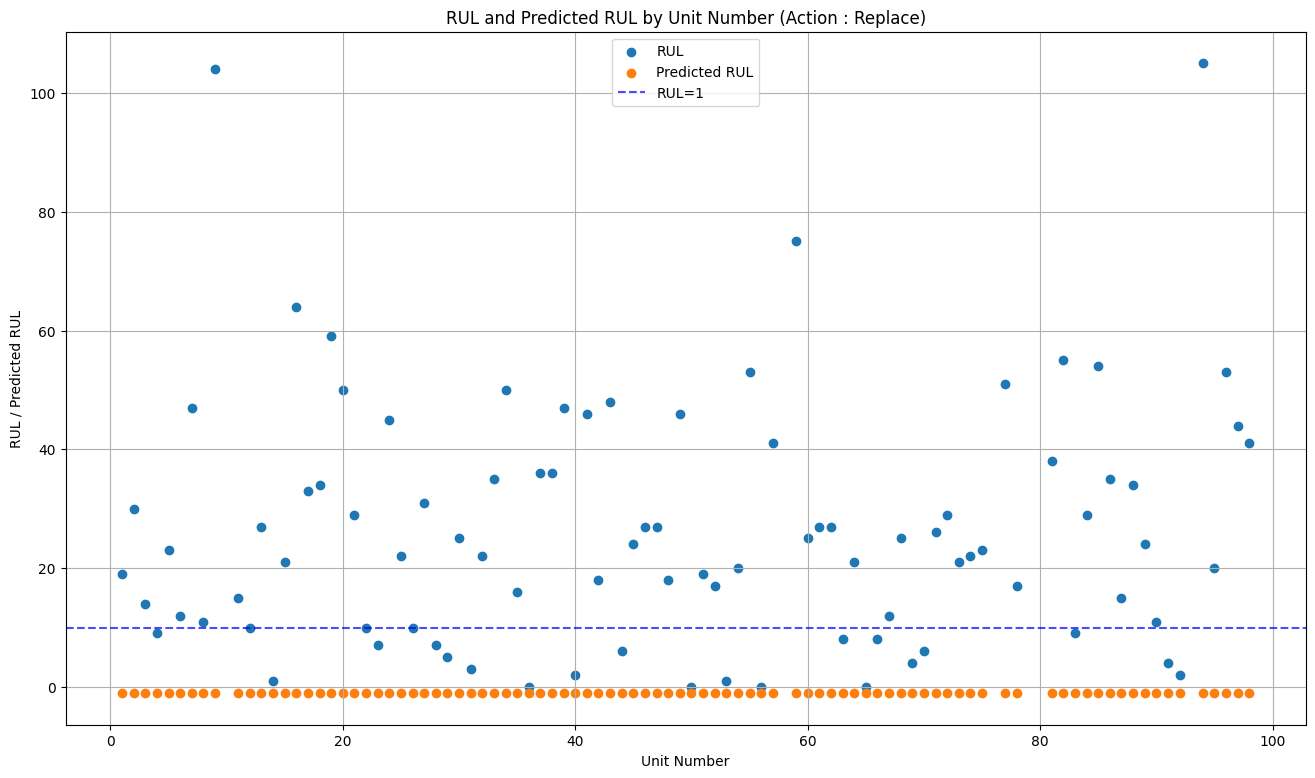

In [644]:
# 데이터프레임에서 'unit_number', 'RUL', 'predicted RUL' 열만 선택
data_to_plot = final_data.loc[replace_indices, ['unit_number', 'RUL', 'predicted RUL']]

# 'unit_number'를 x축으로, 'RUL'을 y축으로 하는 산점도 그리기
plt.figure(figsize=(16, 9))
plt.scatter(data_to_plot['unit_number'], data_to_plot['RUL'], label='RUL')
plt.scatter(data_to_plot['unit_number'], data_to_plot['predicted RUL'], label='Predicted RUL')

# index 5629인 data 추가 (replace failure)
#data_5629 = final_data.loc[5629, ['unit_number', 'RUL', 'predicted RUL']]
#plt.scatter(data_5629['unit_number'], data_5629['RUL'], c='tab:blue')
#plt.scatter(data_5629['unit_number'], data_5629['predicted RUL'], c='tab:orange')

# unit_number 28에 수직 점선 추가 (replace failure가 보이도록)
#unit_28_data = data_to_plot[data_to_plot['unit_number'] == 28]
#plt.axvline(x=28, color='red', linestyle='--', alpha = 0.3, label='Replace failure')
# 점선 옆에 text 추가
#plt.text(29, 26, 'Unit 28 (replace failure)', rotation=0, color='red')

# RUL = 10 점선 추가 (threshold)
plt.axhline(y=10, color='blue', linestyle='--', label='RUL=1', alpha = 0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL / Predicted RUL')
plt.title('RUL and Predicted RUL by Unit Number (Action : Replace)')
plt.legend()
plt.grid(True)
plt.show()

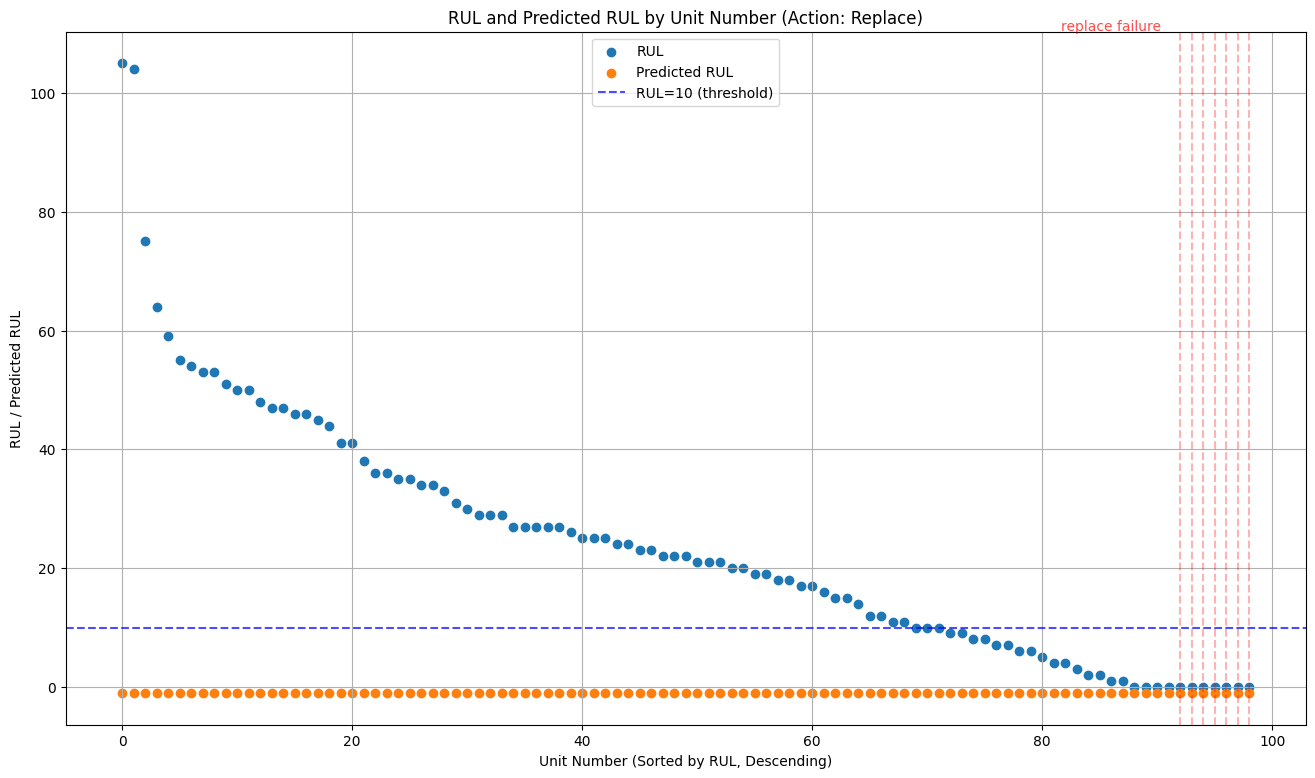

In [645]:
# 데이터프레임에서 'unit_number', 'RUL', 'predicted RUL' 열만 선택
data_to_plot = final_data.loc[replace_indices, ['unit_number', 'RUL', 'predicted RUL']]

# 'unit_number'를 RUL을 기준으로 내림차순으로 정렬하여 정렬된 순서를 저장
sorted_order = data_to_plot.sort_values(by='RUL', ascending=False).index

# 그래프 그리기
plt.figure(figsize=(16, 9))
plt.scatter(range(len(data_to_plot)), data_to_plot.loc[sorted_order, 'RUL'], label='RUL')
plt.scatter(range(len(data_to_plot)), data_to_plot.loc[sorted_order, 'predicted RUL'], label='Predicted RUL')

# replace failure data 추가, sorting 된 plot 오른쪽 끝에 삽입.
failure_1 = final_data.loc[13080, ['unit_number', 'RUL', 'predicted RUL']]
failure_2 = final_data.loc[13656, ['unit_number', 'RUL', 'predicted RUL']]
failure_3 = final_data.loc[14570, ['unit_number', 'RUL', 'predicted RUL']]
failure_4 = final_data.loc[14963, ['unit_number', 'RUL', 'predicted RUL']]
failure_5 = final_data.loc[16128, ['unit_number', 'RUL', 'predicted RUL']]
failure_6 = final_data.loc[19631, ['unit_number', 'RUL', 'predicted RUL']]
failure_7 = final_data.loc[22620, ['unit_number', 'RUL', 'predicted RUL']]

plt.scatter(len(data_to_plot), failure_1['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot), failure_1['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 1, failure_2['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 1, failure_2['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 2, failure_3['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 2, failure_3['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 3, failure_4['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 3, failure_4['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 4, failure_5['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 4, failure_5['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 5, failure_6['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 5, failure_6['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 6, failure_7['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 6, failure_7['predicted RUL'], c='tab:orange')

# 수직 점선 추가 (replace failure 강조)
plt.axvline(x=len(data_to_plot), color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 1, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 2, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 3, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 4, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 5, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 6, color='red', linestyle='--', alpha=0.3)

# 점선 옆에 text 추가
plt.text(x=(len(data_to_plot) - 6), y=110, s='replace failure', fontsize=10, ha='center', va='bottom', color='red', alpha=0.7)

# RUL = 10 점선 추가 (threshold)
plt.axhline(y=10, color='blue', linestyle='--', label='RUL=10 (threshold)', alpha = 0.7)

plt.xlabel('Unit Number (Sorted by RUL, Descending)')
plt.ylabel('RUL / Predicted RUL')
plt.title('RUL and Predicted RUL by Unit Number (Action: Replace)')
plt.legend()
plt.grid(True)
plt.show()

**List comprehension으로 모든 값에서 1을 뺌 (replace 직전 index의 predicted_RUL) 확인을 위해**

In [646]:
before_replace_indices = [index - 1 for index in replace_indices]

In [647]:
for index in before_replace_indices:
    # final_data에서 해당 인덱스의 행 선택하여 필요한 열 출력
    row = final_data.loc[[index], ['unit_number', 'RUL', 'predicted RUL']]
    print(row)

     unit_number  RUL  predicted RUL
238            1   20      -0.967517
     unit_number  RUL  predicted RUL
480            2   31      -0.937571
     unit_number  RUL  predicted RUL
718            3   15      -0.964098
     unit_number  RUL  predicted RUL
995            4   10      -0.985314
      unit_number  RUL  predicted RUL
1194            5   24      -0.958042
      unit_number  RUL  predicted RUL
1483            6   13      -0.989999
      unit_number  RUL  predicted RUL
1872            7   48      -0.966164
      unit_number  RUL  predicted RUL
2175            8   12      -0.995696
      unit_number  RUL  predicted RUL
2488            9  105      -0.954386
      unit_number  RUL  predicted RUL
3255           11   16      -0.995411
      unit_number  RUL  predicted RUL
3430           12   11      -0.979439
      unit_number  RUL  predicted RUL
3598           13   28      -0.967453
      unit_number  RUL  predicted RUL
3831           14    2      -0.979711
      unit_number  R

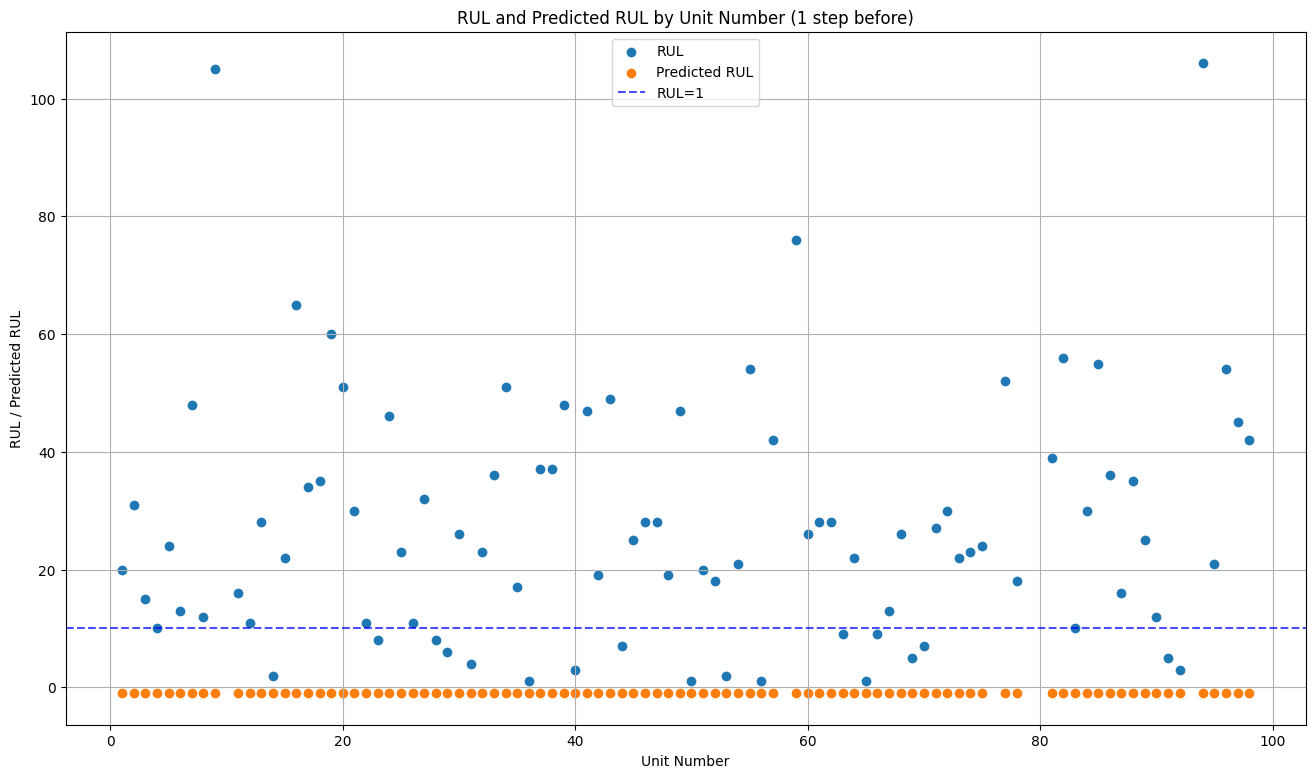

In [648]:
# 데이터프레임에서 'unit_number', 'RUL', 'predicted RUL' 열만 선택
data_to_plot = final_data.loc[before_replace_indices, ['unit_number', 'RUL', 'predicted RUL']]

# 'unit_number'를 x축으로, 'RUL'을 y축으로 하는 산점도 그리기
plt.figure(figsize=(16, 9))
plt.scatter(data_to_plot['unit_number'], data_to_plot['RUL'], label='RUL')
plt.scatter(data_to_plot['unit_number'], data_to_plot['predicted RUL'], label='Predicted RUL')

# index 5629인 data 추가 (replace failure)
#data_5629 = final_data.loc[5628, ['unit_number', 'RUL', 'predicted RUL']]
#plt.scatter(data_5629['unit_number'], data_5629['RUL'], c='tab:blue')
#plt.scatter(data_5629['unit_number'], data_5629['predicted RUL'], c='tab:orange')

# unit_number 28에 수직 점선 추가 (replace failure가 보이도록)
#unit_28_data = data_to_plot[data_to_plot['unit_number'] == 28]
#plt.axvline(x=28, color='red', linestyle='--', alpha = 0.3, label='Replace failure')
# 점선 옆에 text 추가
#plt.text(29, 25, 'Unit 28 (next step : replace failure)', rotation=0, color='red')

# RUL = 10 점선 추가 (threshold)
plt.axhline(y=10, color='blue', linestyle='--', label='RUL=1', alpha = 0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL / Predicted RUL')
plt.title('RUL and Predicted RUL by Unit Number (1 step before)')
plt.legend()
plt.grid(True)
plt.show()

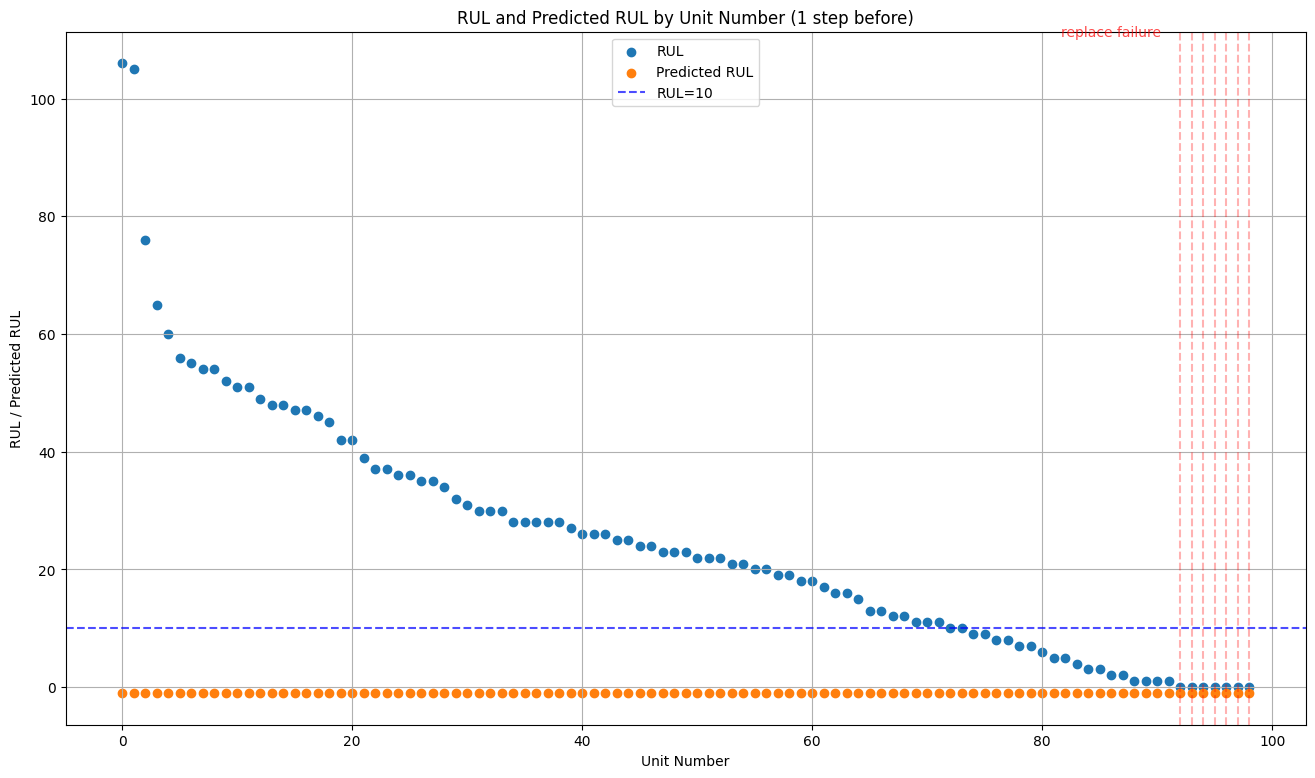

In [649]:
# 데이터프레임에서 'unit_number', 'RUL', 'predicted RUL' 열만 선택
data_to_plot = final_data.loc[before_replace_indices, ['unit_number', 'RUL', 'predicted RUL']]

# 'unit_number'를 RUL을 기준으로 내림차순으로 정렬하여 정렬된 순서를 저장
sorted_order = data_to_plot.sort_values(by='RUL', ascending=False).index

# 그래프 그리기
plt.figure(figsize=(16, 9))
plt.scatter(range(len(data_to_plot)), data_to_plot.loc[sorted_order, 'RUL'], label='RUL')
plt.scatter(range(len(data_to_plot)), data_to_plot.loc[sorted_order, 'predicted RUL'], label='Predicted RUL')

plt.scatter(len(data_to_plot), failure_1['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot), failure_1['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 1, failure_2['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 1, failure_2['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 2, failure_3['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 2, failure_3['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 3, failure_4['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 3, failure_4['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 4, failure_5['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 4, failure_5['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 5, failure_6['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 5, failure_6['predicted RUL'], c='tab:orange')
plt.scatter(len(data_to_plot) + 6, failure_7['RUL'], c='tab:blue')
plt.scatter(len(data_to_plot) + 6, failure_7['predicted RUL'], c='tab:orange')

# 수직 점선 추가 (replace failure 강조)
plt.axvline(x=len(data_to_plot), color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 1, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 2, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 3, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 4, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 5, color='red', linestyle='--', alpha=0.3)
plt.axvline(x=len(data_to_plot) + 6, color='red', linestyle='--', alpha=0.3)

# 점선 옆에 text 추가
plt.text(x=(len(data_to_plot) - 6), y=110, s='replace failure', fontsize=10, ha='center', va='bottom', color='red', alpha=0.7)

# RUL = 10 점선 추가 (threshold)
plt.axhline(y=10, color='blue', linestyle='--', label='RUL=10', alpha = 0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL / Predicted RUL')
plt.title('RUL and Predicted RUL by Unit Number (1 step before)')
plt.legend()
plt.grid(True)
plt.show()

**Q-continue와 Q-replace plot**

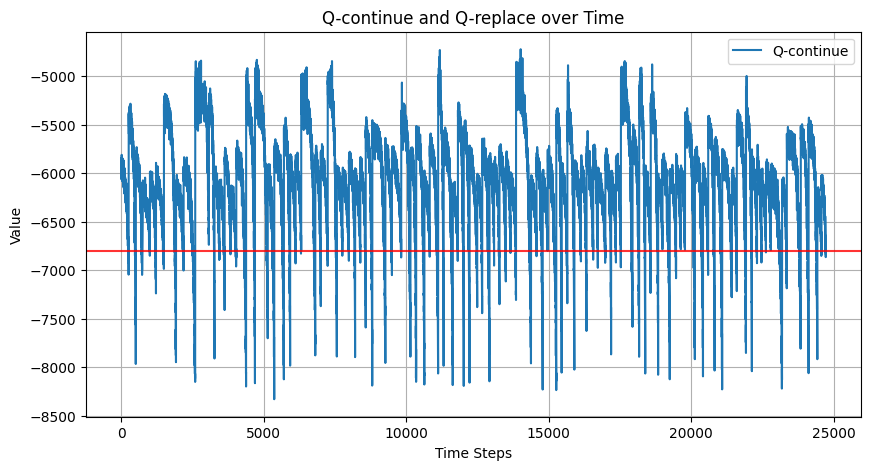

In [650]:
# 데이터 프레임에서 'Q-continue'와 'Q-replace' 열 선택
q_continue = RL_results['Q-continue']
#q_replace = RL_results['Q-replace']

plt.figure(figsize=(10, 5))
plt.plot(q_continue, label='Q-continue', linestyle='-', alpha = 1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.title('Q-continue and Q-replace over Time')
plt.grid(True)

# q_replace 점선 추가 (threshold)
plt.axhline(y=best_weights['replace'], color='red', linestyle='-', label='RUL=10', alpha = 0.8)


plt.show()

**Replace failure 확인**

In [651]:
final_data.loc[[5629]]

unit_number  time_cycles  setting_1  setting_2  setting_3  s_0  s_1  \
5629           20          262    -0.0011       -0.0      100.0    1  0.0   

           s_2       s_3       s_4  ...      s_15  s_16      s_17  s_18  s_19  \
5629  0.384075  0.461538  0.524337  ...  0.409223   0.0  0.363636   0.0   0.0   

          s_20      s_21  RUL  predicted RUL   Q-continue  
5629  0.654762  0.658967   76      -0.930607 -6541.216784  

[1 rows x 30 columns]

**Online prediction 시각화**

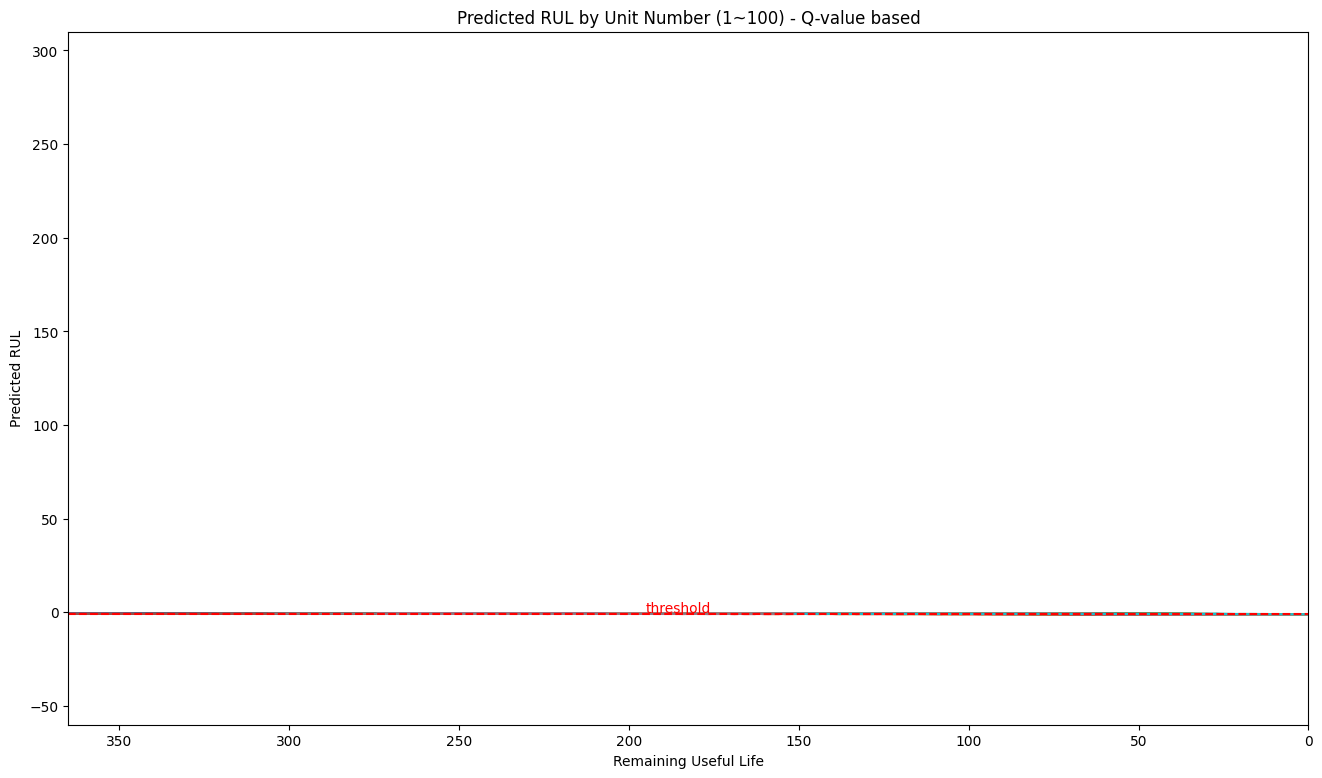

In [652]:
# 데이터프레임에서 unit_number을 기준으로 그룹화
grouped = final_data.groupby('unit_number')

# 그래프를 그릴 subplot을 설정
fig, ax = plt.subplots(figsize=(16, 9))

# unit_number 별로 그래프 그리기
for unit, group in grouped:
    ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

ax.axhline(y=-1, color='r', linestyle='--', label='threshold')  # threshold를 점선으로 표현
ax.text(195, 0, 'threshold', color='r')  # 'threshold' 텍스트 추가


ax.set_xlabel('Remaining Useful Life')
ax.set_ylabel('Predicted RUL')
ax.set_title(f'Predicted RUL by Unit Number (1~100) - Q-value based')
#ax.legend(loc='upper right')  # 범례 추가

# 그래프 출력 설정
plt.xlim(365, 0)  # reverse the x-axis so RUL counts down to zero
plt.ylim(-60, 310)
plt.show()

**online prediction 확대**

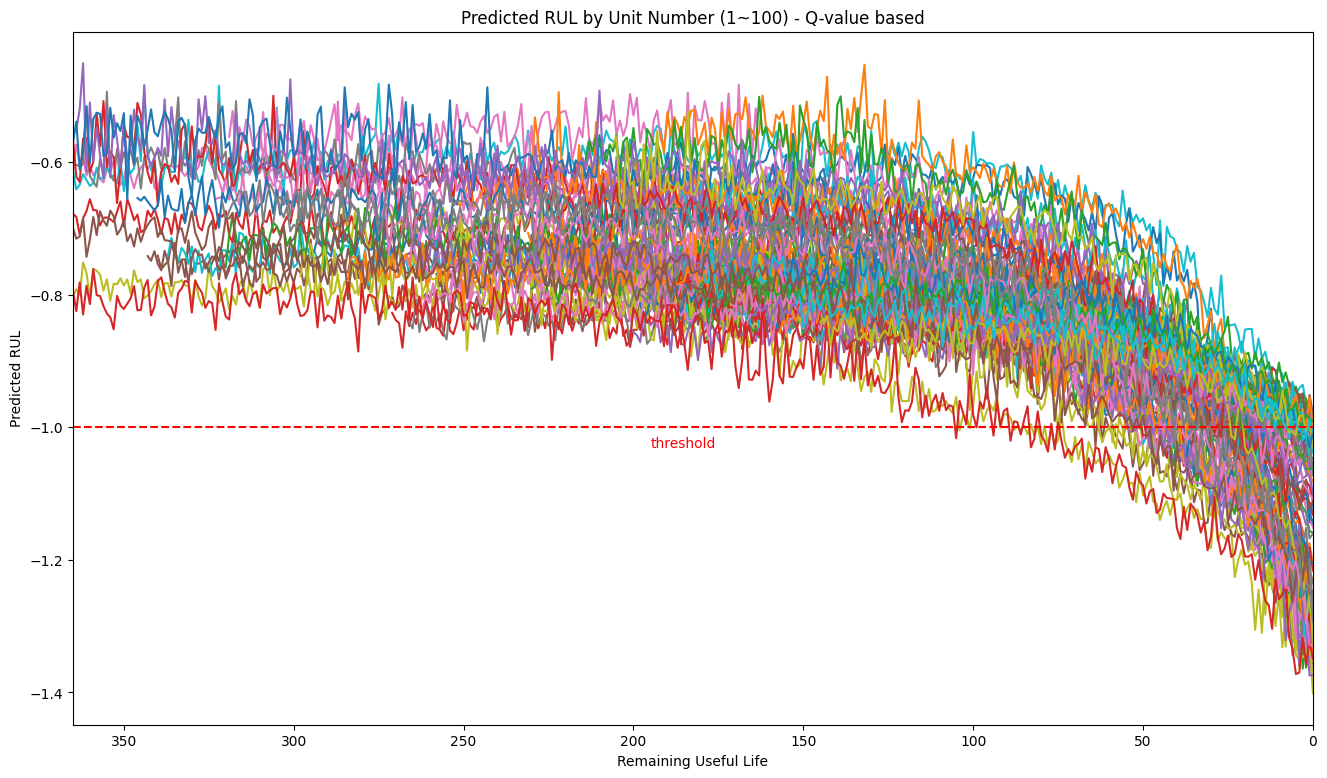

In [653]:
# 데이터프레임에서 unit_number을 기준으로 그룹화
grouped = final_data.groupby('unit_number')

# 그래프를 그릴 subplot을 설정
fig, ax = plt.subplots(figsize=(16, 9))

# unit_number 별로 그래프 그리기
for unit, group in grouped:
    ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

ax.axhline(y=-1, color='r', linestyle='--', label='threshold')  # threshold를 점선으로 표현
ax.text(195, -1.03, 'threshold', color='r')  # 'threshold' 텍스트 추가


ax.set_xlabel('Remaining Useful Life')
ax.set_ylabel('Predicted RUL')
ax.set_title(f'Predicted RUL by Unit Number (1~100) - Q-value based')
#ax.legend(loc='upper right')  # 범례 추가

# 그래프 출력 설정
plt.xlim(365, 0)  # reverse the x-axis so RUL counts down to zero
#plt.ylim(-60, 310)
plt.show()

**비교를 위해 unit_number 71~100만 출력.**

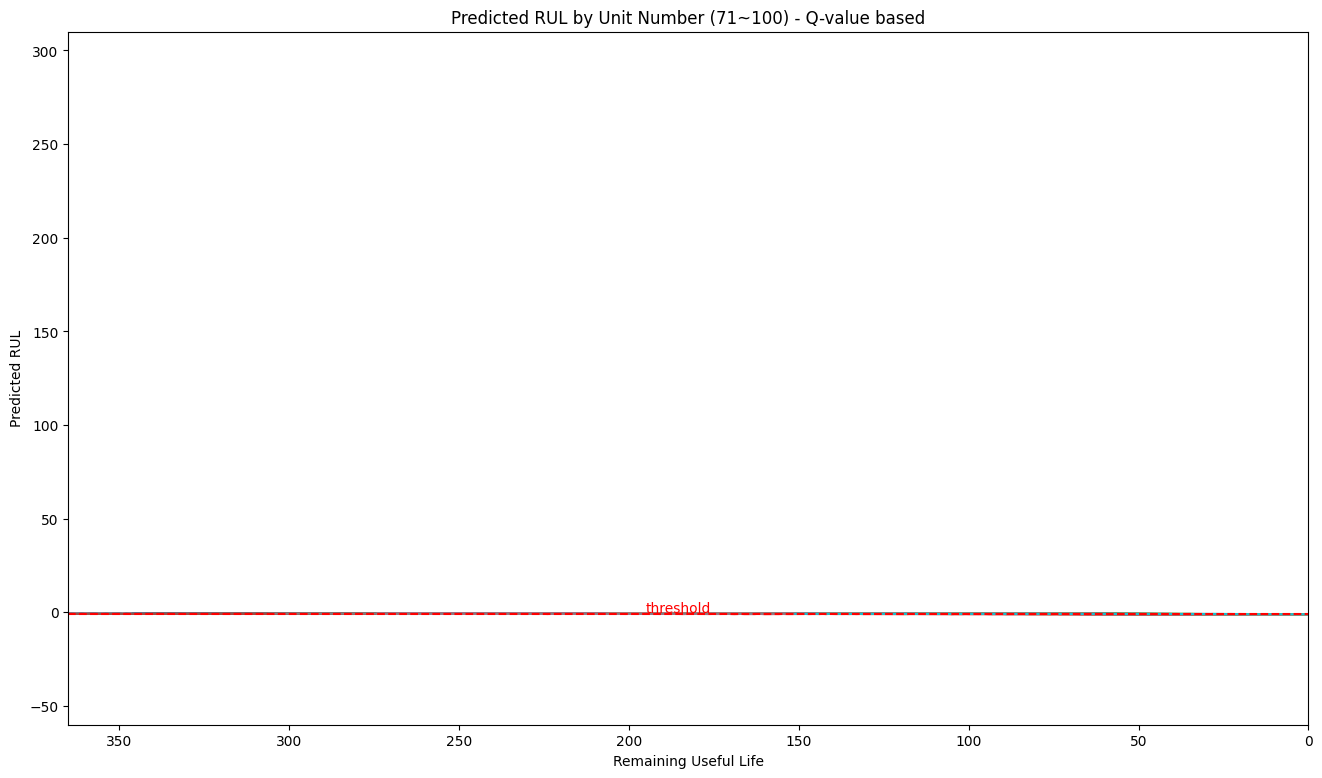

In [654]:
# 데이터프레임에서 unit_number을 기준으로 그룹화
filtered_data = final_data[(final_data['unit_number'] >= 71) & (final_data['unit_number'] <= 100)]  # 71~100 범위의 unit_number 필터링
grouped = filtered_data.groupby('unit_number')

# 그래프를 그릴 subplot을 설정
fig, ax = plt.subplots(figsize=(16, 9))

# unit_number 별로 그래프 그리기
for unit, group in grouped:
    ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

ax.axhline(y=-1, color='r', linestyle='--', label='threshold')  # threshold를 점선으로 표현
ax.text(195, 0, 'threshold', color='r')  # 'threshold' 텍스트 추가

ax.set_xlabel('Remaining Useful Life')
ax.set_ylabel('Predicted RUL')
ax.set_title(f'Predicted RUL by Unit Number (71~100) - Q-value based')

# 범례 추가
#ax.legend(loc='upper right')

# 그래프 출력 설정
plt.xlim(365, 0)  # reverse the x-axis so RUL counts down to zero
plt.ylim(-60, 310)
plt.show()

**online prediction 확대**

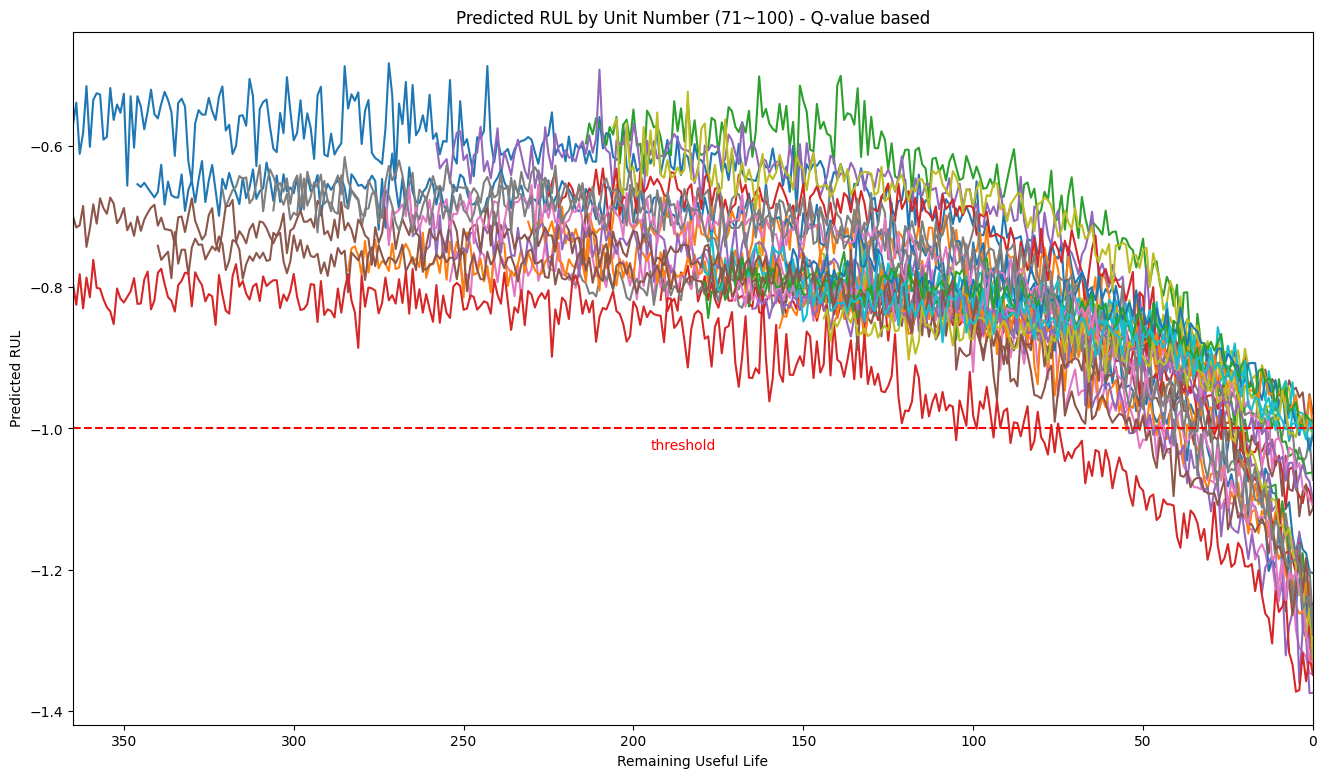

In [655]:
# 데이터프레임에서 unit_number을 기준으로 그룹화
filtered_data = final_data[(final_data['unit_number'] >= 71) & (final_data['unit_number'] <= 100)]  # 71~100 범위의 unit_number 필터링
grouped = filtered_data.groupby('unit_number')

# 그래프를 그릴 subplot을 설정
fig, ax = plt.subplots(figsize=(16, 9))

# unit_number 별로 그래프 그리기
for unit, group in grouped:
    ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

ax.axhline(y=-1, color='r', linestyle='--', label='threshold')  # threshold를 점선으로 표현
ax.text(195, -1.03, 'threshold', color='r')  # 'threshold' 텍스트 추가

ax.set_xlabel('Remaining Useful Life')
ax.set_ylabel('Predicted RUL')
ax.set_title(f'Predicted RUL by Unit Number (71~100) - Q-value based')

# 범례 추가
#ax.legend(loc='upper right')

# 그래프 출력 설정
plt.xlim(365, 0)  # reverse the x-axis so RUL counts down to zero
#plt.ylim(-60, 310)
plt.show()